<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/SDS_FeatureEngineering_Sampling_Template_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3조. 건강검진 데이터를 활용한 치석 발생 예측

## - Version 3. 변수 파생 (Next Step. 추가 외부 변수 결합)'

## 1. 작업 환경 세팅

### 1-1. 구글 드라이브 인증

In [156]:
# Auth 인증 및 Google Drive 활용 Data load
# from google.colab import auth
# auth.authenticate_user()
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# 학교 g guite 사용 시: 학교 g suite 구글 드라이브에 연결해 놓았으니, 성대 킹고 로그인해서 구글 드라이브 켜놓고 아래 결과창에 나오는 url 클릭해서 성대 gmail로 로그인하면 됨
# 데이터 경로는 본인 drive 내의 /sds/data 경로로 fixdm

# Google Drive 내 Custom Class 경로 지정
import sys
sys.path.insert(0, '/gdrive/My Drive/CustomClasses')

Mounted at /gdrive


In [157]:
!ls /gdrive/My\ Drive/sds/data

 구강검진결과_14년도_작업완료.csv
'KOSIS 연령별 성별 치과 평균 수진횟수 2014.csv'
 NHIS_OPEN_GJ_2013.csv
 NHIS_OPEN_GJ_2014.csv
 NHIS_OPEN_GJ_2015.csv
 NHIS_OPEN_GJ_2016.csv
 NHIS_OPEN_GJ_2017.csv
'NHIS_OPEN_GJ 건강검진 데이터 연도별 데이터 레이아웃.xlsx'
 NHIS_OPEN_T20_2012.csv
 NHIS_OPEN_T20_2013.csv
 NHIS_OPEN_T20_2014.csv
 NHIS_OPEN_T20_2015.csv
 NHIS_OPEN_T20_2016.csv
 NHIS_OPEN_T20_2017.csv
'NHIS_OPEN_T20 진료내역정보_활용방안.txt'


### 1-2. 라이브러리 로딩

In [0]:
# 기본 라이브러리 로드
import pandas as pd

# pd.set_option('display.float_format', '{:.6f}'.format) # 항상 float 형식으로
# pd.set_option('display.float_format', '{:.2e}'.format) # 항상 사이언티픽
# pd.set_option('display.float_format', '{:.2g}'.format)  # 적당히 알아서
# pd.set_option('display.float_format', None) # option 삭제

import numpy as np
import os, sys

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

# Deep Learning Model 로드
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.wrappers.scikit_learn import KerasClassifier

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

In [159]:
# 한글 글꼴 최초 설치 Version
!apt-get update -qq
!apt-get install fonts-nanum* -qq
# !cp /usr/share/fonts/truetype/nanum/NanumGothicEco.ttf /gdrive/My\ Drive/CustomClasses/NanumGothicEco.ttf
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자

# 한글 글꼴 Load
# path = '/gdrive/My Drive/CustomClasses/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

# fm._rebuild()
fm._rebuild()

cp: cannot create regular file '/gdrive/My Drive/CustomClasses/NanumGothicEco.ttf': No such file or directory
NanumGothic Eco


## 2. 파일 Read 및 기초 탐색

In [160]:
# # DataFrame Load --------- 2개년도 기준 데이터 추출 및 병합

# df_raw_2014 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2014.csv', encoding = 'euc-kr')
# df_raw_2015 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2015.csv', encoding = 'euc-kr')

# # 컬럼명 내 불필요한 공백 및 특수문자 제거
# df_raw_2014.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)
# df_raw_2015.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# # 데이터 구조 확인
# display(df_raw_2014.head(2))
# display(df_raw_2015.head(2))

# # 데이터 결합 및 구강검진검수여부
# df_raw = pd.concat([df_raw_2014, df_raw_2015])
# df_raw = df_raw[df_raw['구강검진수검여부']==1]

# len(df_raw)

#### 2013년 기준 #########################################################################################################################################
# # 참고 - 데이터 concat시 index 문제로 병합이 안되면 아래 코드 수행 후 다시 concat
# # df_raw.drop_duplicates() #df_raw.reset_index() # df_raw.info()

df_raw_2013 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2013.csv', encoding = 'euc-kr')

# 컬럼명 내 불필요한 공백 및 특수문자 제거
df_raw_2013.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)
df_raw = df_raw_2013[df_raw_2013['구강검진수검여부']==1]
display(df_raw.sample(5))

# # 참고 - 데이터 concat시 index 문제로 병합이 안되면 아래 코드 수행 후 다시 concat
# # df_raw.drop_duplicates() #df_raw.reset_index() # df_raw.info()

####  2015년 기준 #########################################################################################################################################
# df_raw_2015 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2015.csv', encoding = 'euc-kr')

# # 컬럼명 내 불필요한 공백 및 특수문자 제거
# df_raw_2015.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)
# df_raw = df_raw_2015[df_raw_2015['구강검진수검여부']==1]
# display(df_raw.sample(5))

,기준년도,가입자일련번호,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,데이터공개일자
385849,2013,465402,1,5,41,175,80,94,0.8,0.9,1.0,1.0,150,100,86,225,151,40,155.0,14.9,1.0,1.0,25,27,21,1.0,1.0,1,0.0,0.0,0.0,0.0,0.0,20151220
116672,2013,802660,2,3,29,155,55,70,1.2,1.2,1.0,1.0,99,62,77,217,88,71,128.0,12.1,1.0,0.6,17,12,15,1.0,1.0,1,1.0,0.0,0.0,1.0,1.0,20151220
332090,2013,529176,1,5,28,180,80,94,1.5,1.5,1.0,1.0,110,70,94,177,126,47,104.0,15.7,1.0,0.9,29,29,39,2.0,0.0,1,0.0,0.0,1.0,0.0,0.0,20151220
376676,2013,532924,1,5,44,160,70,88,1.2,1.2,1.0,1.0,120,80,219,205,139,39,138.0,13.8,1.0,1.2,21,30,23,2.0,1.0,1,0.0,0.0,0.0,0.0,0.0,20151220
865260,2013,762377,2,10,27,140,55,79,0.5,1.0,1.0,1.0,110,70,108,192,112,50,120.0,12.7,1.0,0.6,21,16,21,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,20151220


### 2-1. 컬럼명 정제 및 기초 탐색

In [161]:
# del_cols = ['기준년도', '가입자일련번호', '치아우식증유무', '결손치유무' ,'치아마모증유무','제3대구치사랑니이상','데이터공개일자', '구강검진수검여부','음주여부']
# 2014 & 2015년도 데이터 기준
# del_cols = ['기준년도', '가입자일련번호', '치아우식증유무', '데이터기준일자', '구강검진수검여부']
# df_raw.drop(columns=del_cols, axis=1, inplace=True)
# df_raw.rename(columns={'치석유무': '치석'}, inplace=True)


#### 2013년 기준 #########################################################################################################################################
del_cols = ['기준년도', '가입자일련번호', '데이터공개일자','구강검진수검여부']
df_raw.drop(columns=del_cols, axis=1, inplace=True)

display(df_raw.head(3))
df_raw.info()

#### 2014년 기준 #########################################################################################################################################
# del_cols = ['기준년도', '가입자일련번호', '데이터기준일자','구강검진수검여부']
# df_raw.drop(columns=del_cols, axis=1, inplace=True)
# df_raw.rename(columns={'치석유무': '치석'}, inplace=True)

# display(df_raw.head(3))
# df_raw.info()

,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석
3,2,1,43,145,40,62,1.0,1.0,1.0,1.0,110,70,75,207,51,87,110.0,12.4,1.0,0.7,14,8,22,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5,2,1,11,145,45,72,0.8,0.2,1.0,1.0,100,53,82,206,101,46,140.0,13.1,1.0,0.8,13,12,13,1.0,1.0,1.0,0.0,0.0,0.0,1.0
9,2,1,43,145,60,81,0.4,0.8,1.0,1.0,119,79,110,216,58,55,1494.0,12.7,1.0,0.6,28,36,25,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 383807 entries, 3 to 999998
Data columns (total 30 columns):
성별코드          383807 non-null int64
연령대코드5세단위     383807 non-null int64
시도코드          383807 non-null int64
신장5Cm단위       383807 non-null int64
체중5Kg단위       383807 non-null int64
허리둘레          383807 non-null int64
시력좌           383738 non-null float64
시력우           383739 non-null float64
청력좌           383752 non-null float64
청력우           383752 non-null float64
수축기혈압         383807 non-null int64
이완기혈압         383807 non-null int64
식전혈당공복혈당      383807 non-null int64
총콜레스테롤        383807 non-null int64
트리글리세라이드      383807 non-null int64
HDL콜레스테롤      383807 non-null int64
LDL콜레스테롤      382246 non-null float64
혈색소           383807 non-null float64
요단백           382432 non-null float64
혈청크레아티닌       383807 non-null float64
혈청지오티AST      383807 non-null int64
혈청지오티ALT      383807 non-null int64
감마지티피         383807 non-null int64
흡연상태          383788 non-null float64
음주여부   

### 2-2. 치석 데이터 분류 있으나 치석 분류가 2가 아닌 데이터만 df_data에 다시 할당

In [162]:
# 타겟 변수 지정
target_nm = '치아우식증유무'
print(df_raw[target_nm].value_counts())

0.0    290368
1.0     93439
Name: 치아우식증유무, dtype: int64


In [0]:
df_data = df_raw[~(df_raw['치석'].isnull()) & (df_raw['치석'] != 2)]

## 3. Simple EDA
1. 데이터 임포트 후 메모리에 upload 
2. 데이터의 모양 확인
3. 데이터의 타입 확인
4. 데이터의 Null 값을 체크
5. 종속변수의 분포 체크
6. 독립변수 - 명목형 변수의 분포 체크
7. 독립변수 - 수치형 변수의 분포 체크
8. 수치형, 명목형 변수간의 관계 파악

### 3-1. 데이터의 모양 및 타입 확인

In [164]:
# EDA 진행 할 데이터 모양 확인 및 데이터 타입 확인
display(df_data.sample(5))
display(df_data.info())

,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석
284498,2,5,27,155,55,80,1.2,1.2,1.0,1.0,116,72,100,168,83,64,86.0,12.3,1.0,0.8,18,13,15,1.0,1.0,1.0,0.0,0.0,0.0,0.0
652972,2,7,43,155,65,89,1.0,0.9,1.0,1.0,124,76,127,154,122,48,82.0,13.5,1.0,0.7,21,15,21,1.0,0.0,0.0,0.0,0.0,0.0,1.0
495430,2,6,11,155,40,59,0.4,0.5,1.0,1.0,109,77,79,193,68,72,107.0,13.1,1.0,0.8,20,12,16,1.0,0.0,0.0,0.0,0.0,0.0,0.0
566097,1,7,11,170,80,89,0.8,1.0,1.0,1.0,110,70,125,169,133,57,85.0,13.4,1.0,1.2,43,43,237,2.0,1.0,0.0,1.0,0.0,0.0,0.0
830269,1,9,11,170,75,94,1.0,1.0,1.0,1.0,137,94,113,170,267,39,77.0,15.4,3.0,1.1,24,18,21,2.0,1.0,0.0,0.0,0.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 383807 entries, 3 to 999998
Data columns (total 30 columns):
성별코드          383807 non-null int64
연령대코드5세단위     383807 non-null int64
시도코드          383807 non-null int64
신장5Cm단위       383807 non-null int64
체중5Kg단위       383807 non-null int64
허리둘레          383807 non-null int64
시력좌           383738 non-null float64
시력우           383739 non-null float64
청력좌           383752 non-null float64
청력우           383752 non-null float64
수축기혈압         383807 non-null int64
이완기혈압         383807 non-null int64
식전혈당공복혈당      383807 non-null int64
총콜레스테롤        383807 non-null int64
트리글리세라이드      383807 non-null int64
HDL콜레스테롤      383807 non-null int64
LDL콜레스테롤      382246 non-null float64
혈색소           383807 non-null float64
요단백           382432 non-null float64
혈청크레아티닌       383807 non-null float64
혈청지오티AST      383807 non-null int64
혈청지오티ALT      383807 non-null int64
감마지티피         383807 non-null int64
흡연상태          383788 non-null float64
음주여부   

None

### 3-2. 데이터 NULL 값 체크

In [165]:
# Null Value Check
print('# Null Value Check in Data \n ---------------------------------------------------- ')
print(df_data.isnull().sum())

# Null Value Check in Data 
 ---------------------------------------------------- 
성별코드             0
연령대코드5세단위        0
시도코드             0
신장5Cm단위          0
체중5Kg단위          0
허리둘레             0
시력좌             69
시력우             68
청력좌             55
청력우             55
수축기혈압            0
이완기혈압            0
식전혈당공복혈당         0
총콜레스테롤           0
트리글리세라이드         0
HDL콜레스테롤         0
LDL콜레스테롤      1561
혈색소              0
요단백           1375
혈청크레아티닌          0
혈청지오티AST         0
혈청지오티ALT         0
감마지티피            0
흡연상태            19
음주여부           103
치아우식증유무          0
결손치유무            0
치아마모증유무          0
제3대구치사랑니이상       0
치석               0
dtype: int64


#### 3-2-1. 데이터 NULL 값의 비중이 크지 않으므로 일단 null 값을 모두 삭졔
 . 가장 많은 Null값을 갖고 있는 요단백의 경우 추후 분석 시, 모델에 끼치는 영향이 크다고 할 시, Imputation 고려

In [166]:
# (일단 임시로) null 포함 데이터 모두 삭제 
df_data.dropna(how='any', inplace=True)
display(df_data.info())
print(len(df_data))

print(df_data[target_nm].value_counts())

# 샘플링을 통해 10만건만 데이터분석
# df_data = df_data.sample(n=100000, random_state=42, replace = False ).copy()
df_sample = df_data.groupby(target_nm).apply(lambda x: x.sample(n=50000)).copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380657 entries, 3 to 999998
Data columns (total 30 columns):
성별코드          380657 non-null int64
연령대코드5세단위     380657 non-null int64
시도코드          380657 non-null int64
신장5Cm단위       380657 non-null int64
체중5Kg단위       380657 non-null int64
허리둘레          380657 non-null int64
시력좌           380657 non-null float64
시력우           380657 non-null float64
청력좌           380657 non-null float64
청력우           380657 non-null float64
수축기혈압         380657 non-null int64
이완기혈압         380657 non-null int64
식전혈당공복혈당      380657 non-null int64
총콜레스테롤        380657 non-null int64
트리글리세라이드      380657 non-null int64
HDL콜레스테롤      380657 non-null int64
LDL콜레스테롤      380657 non-null float64
혈색소           380657 non-null float64
요단백           380657 non-null float64
혈청크레아티닌       380657 non-null float64
혈청지오티AST      380657 non-null int64
혈청지오티ALT      380657 non-null int64
감마지티피         380657 non-null int64
흡연상태          380657 non-null float64
음주여부   

None

380657
0.0    288017
1.0     92640
Name: 치아우식증유무, dtype: int64


### 3-3. 데이터 Unique 값 체크

In [167]:
print('## Unique Value Check')
print("-"*25)
print('# Col Name: Unique Value / Total Size')
print("-"*25)

for col in df_data.columns:
    print(col, ':', df_sample[col].unique().size, '/', len(df_sample[col]))  

## Unique Value Check
-------------------------
# Col Name: Unique Value / Total Size
-------------------------
성별코드 : 2 / 100000
연령대코드5세단위 : 14 / 100000
시도코드 : 17 / 100000
신장5Cm단위 : 13 / 100000
체중5Kg단위 : 20 / 100000
허리둘레 : 73 / 100000
시력좌 : 20 / 100000
시력우 : 20 / 100000
청력좌 : 2 / 100000
청력우 : 2 / 100000
수축기혈압 : 132 / 100000
이완기혈압 : 92 / 100000
식전혈당공복혈당 : 325 / 100000
총콜레스테롤 : 308 / 100000
트리글리세라이드 : 809 / 100000
HDL콜레스테롤 : 172 / 100000
LDL콜레스테롤 : 343 / 100000
혈색소 : 150 / 100000
요단백 : 6 / 100000
혈청크레아티닌 : 86 / 100000
혈청지오티AST : 269 / 100000
혈청지오티ALT : 305 / 100000
감마지티피 : 554 / 100000
흡연상태 : 3 / 100000
음주여부 : 2 / 100000
치아우식증유무 : 2 / 100000
결손치유무 : 2 / 100000
치아마모증유무 : 2 / 100000
제3대구치사랑니이상 : 2 / 100000
치석 : 2 / 100000


### 3-4. Data Wrangling
#### - 데이터 의미에 맞게 연속형, 범주형으로 변형

In [168]:
# 범주형, 연속형 변수 type 지정
# 명목형 변수는 obj로 연속형 변수는 int 또는 float로 변경

# 2014, 2015년도 데이터 기준
category_features = ['성별코드', '연령대코드5세단위', '신장5Cm단위', '체중5Kg단위','시도코드', '청력좌', '청력우', '흡연상태','음주여부', '요단백']

# 2013년도 데이터 기준
# category_features = ['성별코드', '연령대코드5세단위', '신장5Cm단위', '체중5Kg단위','시도코드', '청력좌', '청력우', '흡연상태','음주여부', '요단백']

for col in df_data.columns:
  if col in category_features:
    df_sample[col] = df_sample[col].astype(object)

print(df_sample.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 100000 entries, (0.0, 396235) to (1.0, 4108)
Data columns (total 30 columns):
성별코드          100000 non-null object
연령대코드5세단위     100000 non-null object
시도코드          100000 non-null object
신장5Cm단위       100000 non-null object
체중5Kg단위       100000 non-null object
허리둘레          100000 non-null int64
시력좌           100000 non-null float64
시력우           100000 non-null float64
청력좌           100000 non-null object
청력우           100000 non-null object
수축기혈압         100000 non-null int64
이완기혈압         100000 non-null int64
식전혈당공복혈당      100000 non-null int64
총콜레스테롤        100000 non-null int64
트리글리세라이드      100000 non-null int64
HDL콜레스테롤      100000 non-null int64
LDL콜레스테롤      100000 non-null float64
혈색소           100000 non-null float64
요단백           100000 non-null object
혈청크레아티닌       100000 non-null float64
혈청지오티AST      100000 non-null int64
혈청지오티ALT      100000 non-null int64
감마지티피         100000 non-null int64
흡연상태          100000 non-n

### 3-5. Target 종속변수 속성 확인

In [169]:
print("Count : \n", df_sample[target_nm].value_counts(), "\n------------------------------\nPortion : \n", df_sample[target_nm].value_counts()/len(df_sample[target_nm]))

Count : 
 1.0    50000
0.0    50000
Name: 치아우식증유무, dtype: int64 
------------------------------
Portion : 
 1.0    0.5
0.0    0.5
Name: 치아우식증유무, dtype: float64


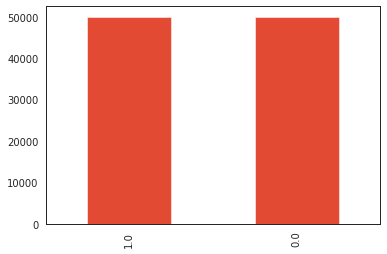

In [170]:
df_sample[target_nm].value_counts().plot(kind='bar') 
plt.show()

### 3-6. 명목형 변수 EDA

#### 3-6-1. 명목형 변수 항목 변환
 - A_성별 --- 성별코드를 '남', '여' 로 변경
 - A_연령대5세단위 --- 연령대코드를 5세 단위 수치로 변경(20~24세는 20으로 표기)
 - A_시도 --- 시도코드를 서울, 경기와 같이 변경
 - A_청력좌, A_청력우 - 청력코드를 정상, 비정상으로 변경
 - A_요단백 - 요단백코드를 정상, 비정상으로 변경
 - A_흡연상태 - 비흡연, 금연, 흡연으로 변경
 - A_음주여부 - 비음주, 음주로 변경

In [171]:
# 성별코드 변환
df_sample["A_성별"] = df_sample["성별코드"].apply(lambda x:  '남' if x == 1 else '여')

# 연령대코드 5세 단위 변환
min_age_code = df_sample["연령대코드5세단위"].min()
print(min_age_code)

df_sample["A_연령대5세단위"] = df_sample["연령대코드5세단위"].apply(lambda x:  (x-1)*5 + 20 if min_age_code == 1 else (x-1)*5).astype(object)

# 시도코드 변환
df_sample["A_시도"] = np.where(df_sample['시도코드'] == 11, '서울', 
                            np.where(df_sample['시도코드']== 26, '부산', 
                              np.where(df_sample['시도코드'] == 27, '대구', 
                                np.where(df_sample['시도코드'] == 28, '인천', 
                                  np.where(df_sample['시도코드'] == 29, '광주', 
                                    np.where(df_sample['시도코드'] == 30, '대전', 
                                      np.where(df_sample['시도코드'] == 31, '울산', 
                                        np.where(df_sample['시도코드'] == 36, '세종', 
                                          np.where(df_sample['시도코드'] == 41, '경기', 
                                            np.where(df_sample['시도코드'] == 42, '강원', 
                                              np.where(df_sample['시도코드'] == 43, '충북', 
                                                np.where(df_sample['시도코드'] == 44, '충남', 
                                                  np.where(df_sample['시도코드'] == 45, '전북', 
                                                    np.where(df_sample['시도코드'] == 46, '전남', 
                                                      np.where(df_sample['시도코드'] == 47, '경북', 
                                                        np.where(df_sample['시도코드'] == 48, '경남', 
                                                          np.where(df_sample['시도코드'] == 49, '제주', '오류')
                                      ))))))))))))))))

# 청력좌  변환
df_sample["A_청력좌"] = df_sample["청력좌"].apply(lambda x:  '정상' if x == 1 else '비정상')

# 청력우  변환
df_sample["A_청력우"] = df_sample["청력우"].apply(lambda x:  '정상' if x == 1 else '비정상')

# 요단백  변환
df_sample["A_요단백"] = df_sample["요단백"].apply(lambda x:  '음성' if x == 1 else '양성')

# 흡연상태  변환
df_sample["A_흡연상태"] = df_sample["흡연상태"].apply(lambda x:  '비흡연' if x == 1 else ('금연' if x==2 else '흡연'))

# 음주여부  변환
df_sample["A_음주여부"] = df_sample["음주여부"].apply(lambda x:  '비음주' if x == 0 else '음주')

1


#### 3-6-1-1 변환 명목형 원 컬럼 삭제
- 변환이전의 코드 형식의 명목형 변수는 필요없으므로 삭제
- 변환이전 코드형식 컬럼 list
- del_obj_trans_cols = ['성별코드', '연령대코드5세단위', '시도코드', '청력좌', '청력우', '요단백', '흡연상태', '음주여부']

In [0]:
# 변환 명목형 원 컬럼 삭제
del_obj_trans_cols = ['성별코드', '연령대코드5세단위', '시도코드', '청력좌', '청력우', '요단백', '흡연상태', '음주여부']
df_sample.drop(columns=del_obj_trans_cols, axis=1, inplace=True)

### 3-6-2. 명목형 변수 추출

In [173]:
# 앞에서 명목형 변수의 형을 object로 모두 변경했기 때문에 컬럼 중에서 object 타입을 가진 컬럼만 뽑아서 명목형 변수의 리스트를 만든다
# 이 때, 데이터의 기본키(인덱스), 종속변수 등을 제외하고 분석하는 것이 좋음

# 단변수 탐색
category_features = [col for col in df_sample.columns if df_sample[col].dtypes == "object"]
print(category_features)

cat_cols = list(set(category_features) - set([target_nm]))
print(cat_cols)

['신장5Cm단위', '체중5Kg단위', 'A_성별', 'A_연령대5세단위', 'A_시도', 'A_청력좌', 'A_청력우', 'A_요단백', 'A_흡연상태', 'A_음주여부']
['A_성별', 'A_청력우', '신장5Cm단위', 'A_음주여부', 'A_흡연상태', '체중5Kg단위', 'A_청력좌', 'A_요단백', 'A_연령대5세단위', 'A_시도']


#### 3-6-3. 명목형 변수 count plot (단변량)

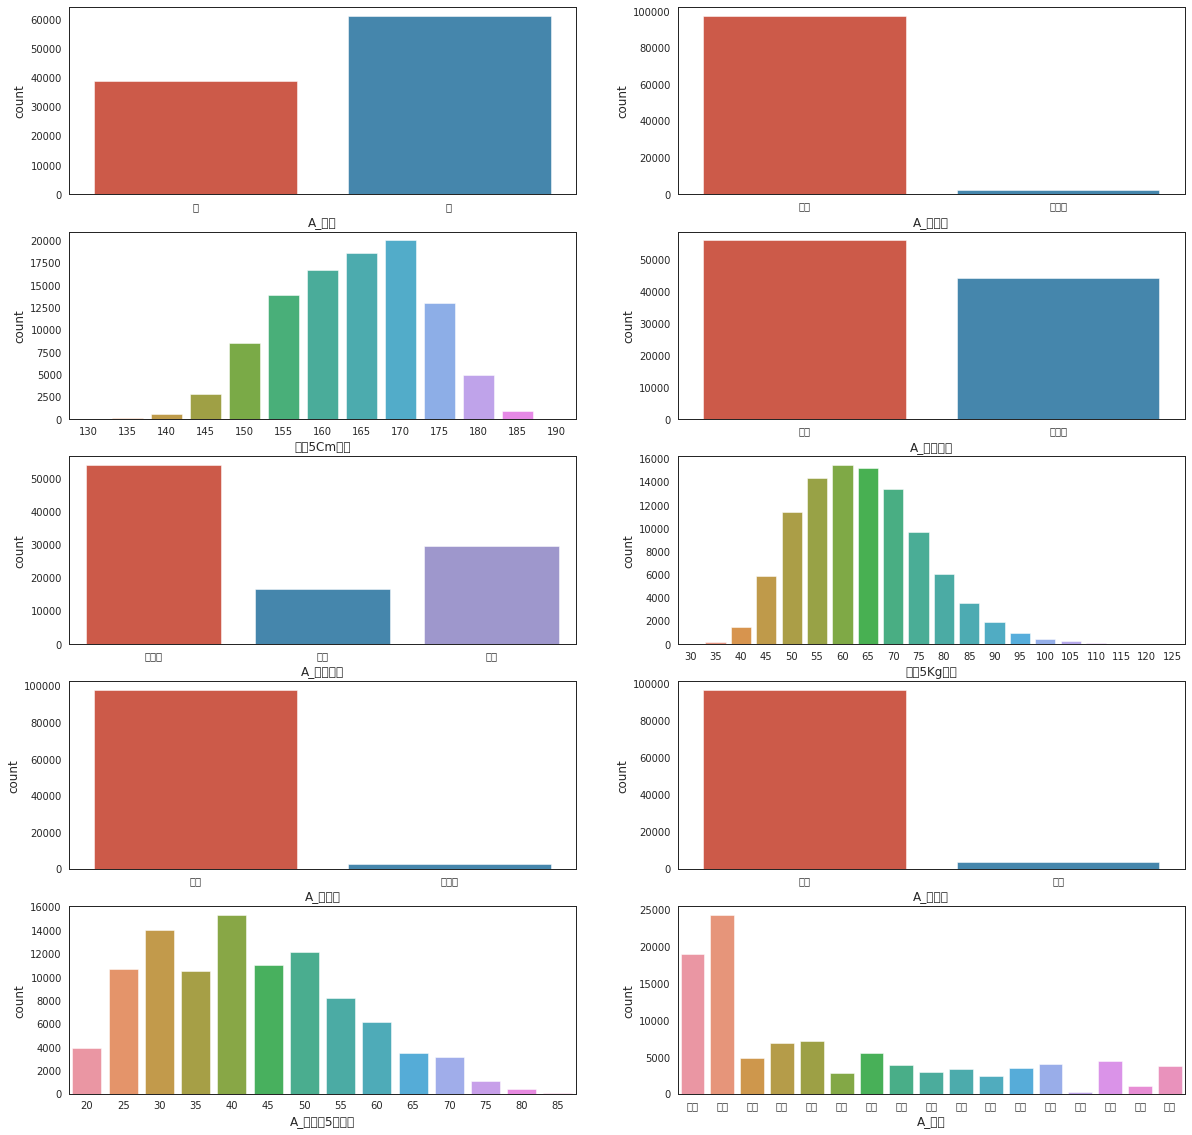

<Figure size 432x288 with 0 Axes>

In [174]:
# 그래프를 통해 명목형 변수의 분포를 체크

fig, saxis = plt.subplots(5, 2, figsize=(20,20))
plt.figure()

# 변수별로 for문을 돌면서 countplot을 그림
for idx, col in enumerate(cat_cols):
  row_loc = idx // 2
  col_loc = idx % 2
  sns.countplot(x=df_sample[col], data= df_sample, ax = saxis[row_loc,col_loc])
#   df_data[col].value_counts().plot(kind='bar', ax = saxis[row_loc,col_loc])
  
plt.show()

#### 3-6-2. 명목형 변수 bar plot(이변량 - "치석" 종속변수와의 관계)

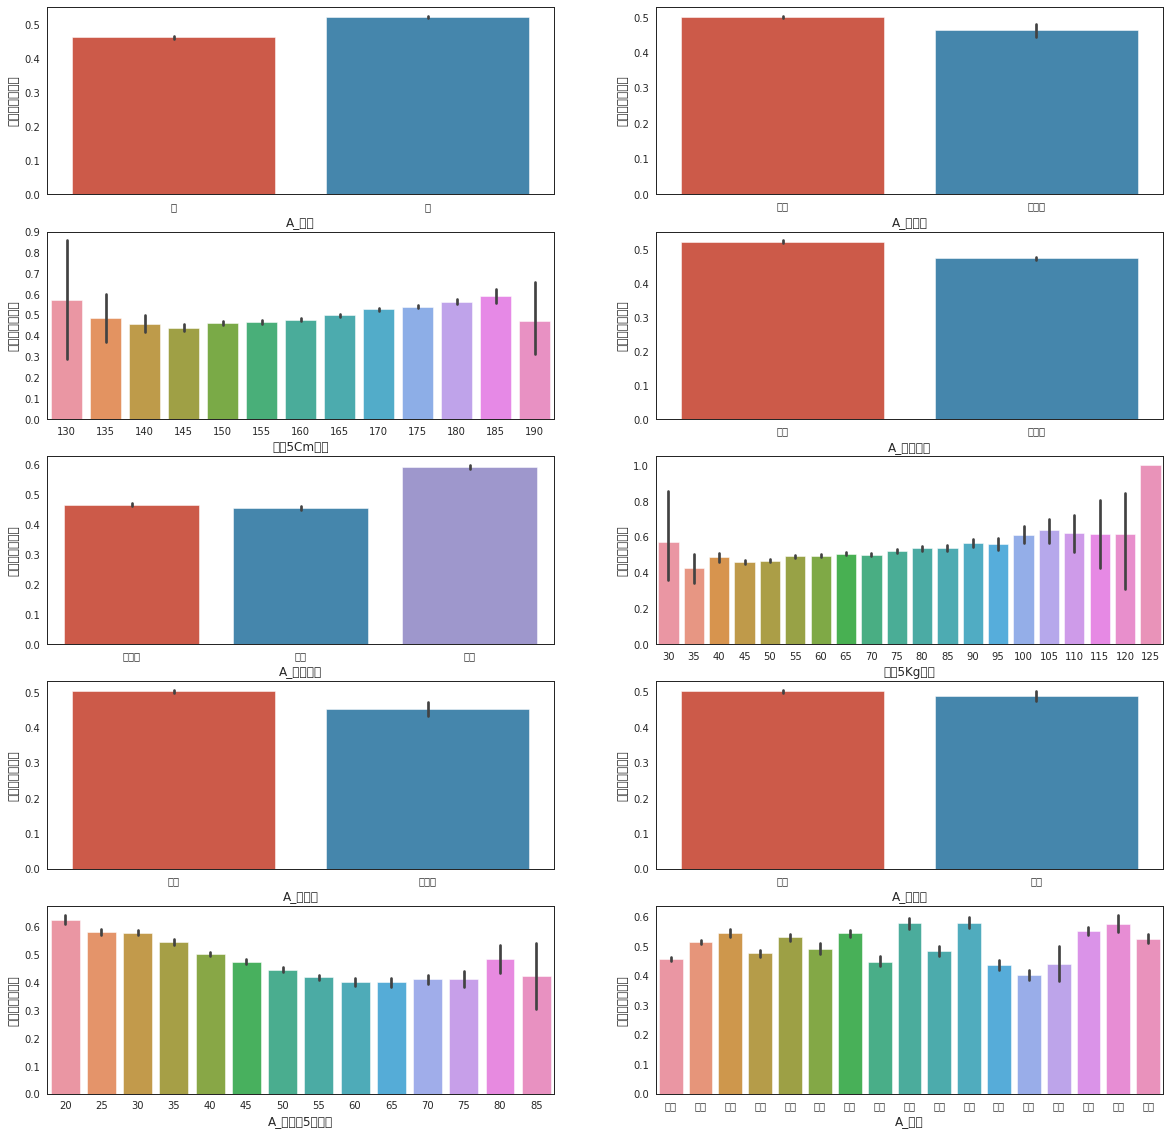

<Figure size 432x288 with 0 Axes>

In [175]:
fig, saxis = plt.subplots(5, 2, figsize=(20,20))
plt.figure()

# 변수별로 for문을 돌면서 barplot 그림
for idx, col in enumerate(cat_cols):
  row_loc = idx // 2
  col_loc = idx % 2
  sns.barplot(x=col, y=target_nm, data= df_sample, ax = saxis[row_loc,col_loc])
  
plt.show()

### 3-7. 수치형 변수 EDA



#### 3-7-2. 수치형 변수 추출 및 확인
- 구강검진으로 나타날 수 있는 타겟 변수들 중 타겟을 제외하고 삭제 필요
- remove_target_candidates = ['치아마모증유무', '치아우식증유무', '제3대구치사랑니이상', '치석', '결손치유무']
- num_cols = list(set(numeric_features) - set(remove_target_candidates))

In [176]:
# 앞에서 명목형 변수의 형을 object로 모두 변경했기 때문에 컬럼 중에서 object 타입을 가진 컬럼만 뽑아서 명목형 변수의 리스트를 만든다
# 이 때, 데이터의 기본키(인덱스), 종속변수 등을 제외하고 분석하는 것이 좋음

# 단변수 탐색
numeric_features = [col for col in df_sample.columns if df_sample[col].dtypes != "object"]
numeric_features = np.sort(numeric_features)

# 구강검진으로 나타날 수 있는 타겟 변수들 : '치아마모증유무', '치아우식증유무', '제3대구치사랑니이상', '치석', '결손치유무'
remove_target_candidates = ['치아마모증유무', '치아우식증유무', '제3대구치사랑니이상', '치석', '결손치유무']
num_cols = list(set(numeric_features) - set(remove_target_candidates))
print(num_cols)

print(len(num_cols)) # 총 15개

['혈색소', '식전혈당공복혈당', '총콜레스테롤', '혈청지오티AST', '시력좌', '감마지티피', 'HDL콜레스테롤', '이완기혈압', '수축기혈압', '트리글리세라이드', 'LDL콜레스테롤', '허리둘레', '혈청크레아티닌', '시력우', '혈청지오티ALT']
15


#### 3-7-3. 수치형 변수 count plot (단변량)

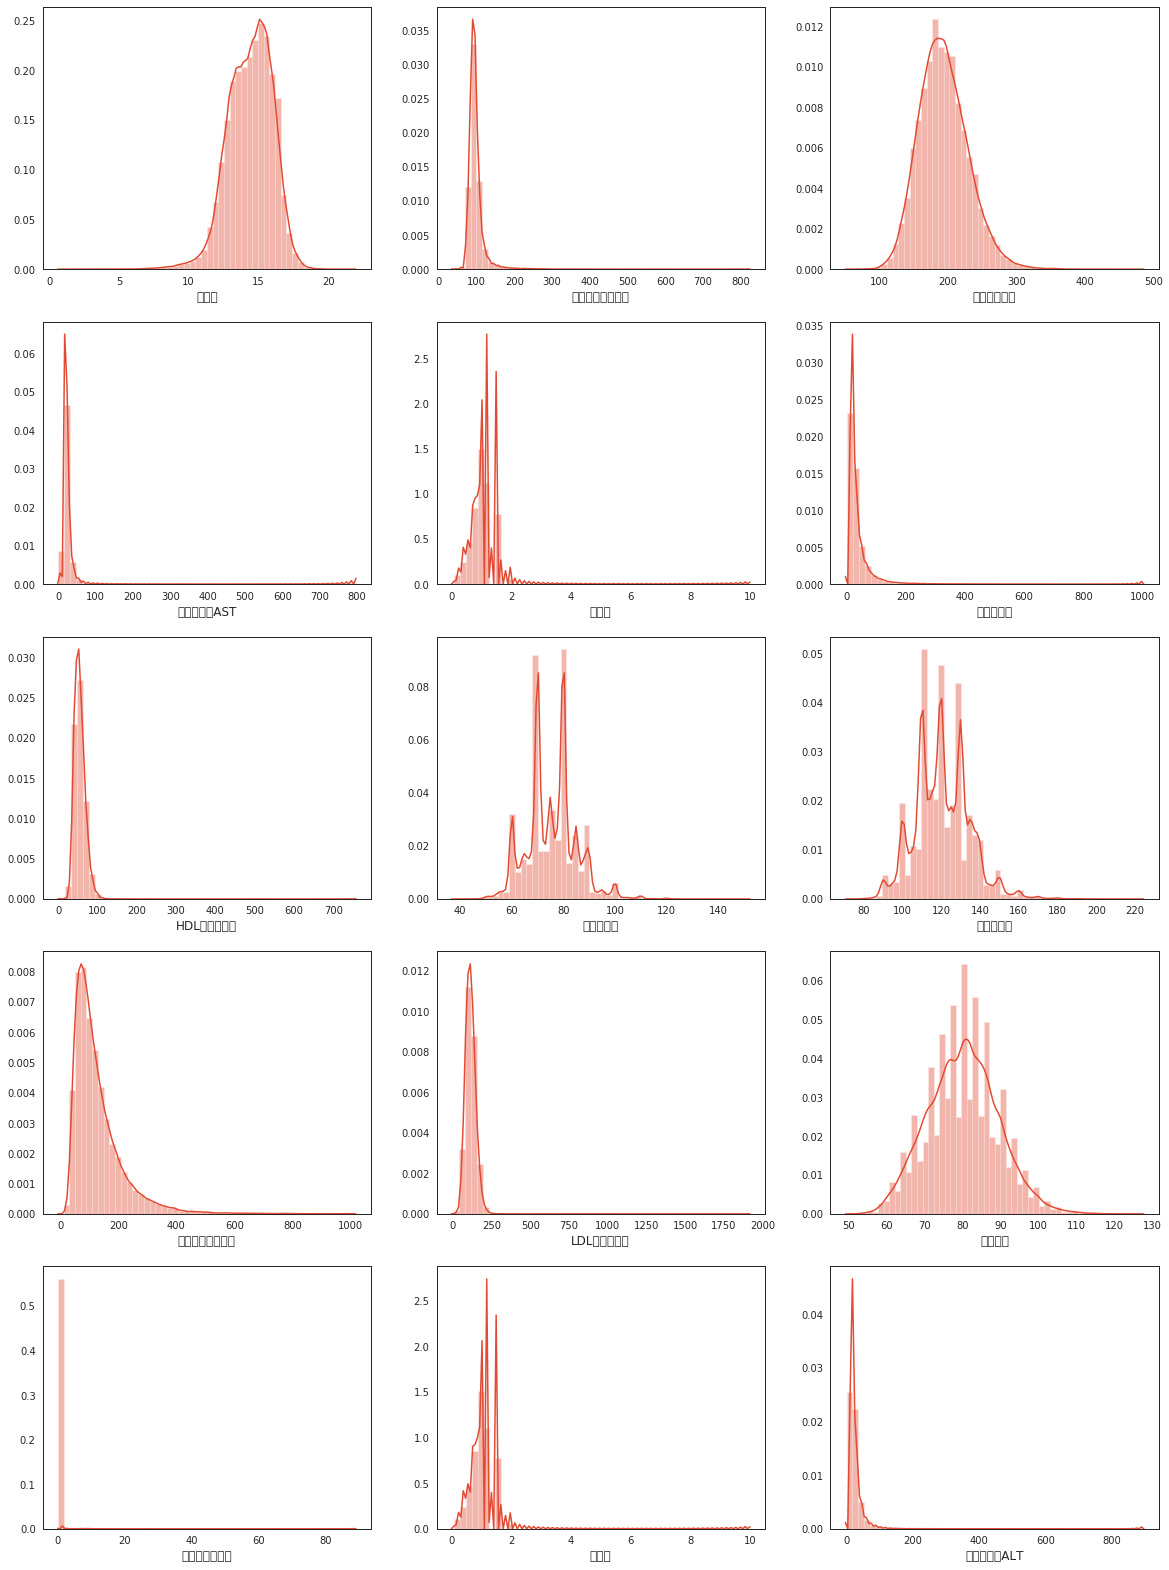

<Figure size 432x288 with 0 Axes>

In [177]:
# 단변수 탐색 - 단변수 탐색은 seaborn 패키지의 distplot 함수를 이용하면 편함
# 수치형 변수만 골라냄
fig, saxis = plt.subplots(5, 3, figsize=(20,28))
plt.figure()

# 변수별로 for문을 돌면서 distplot을 그림
for idx, col in enumerate(num_cols):
    row_loc = idx // 3
    col_loc = idx % 3
    sns.distplot(df_sample.loc[df_sample[col].notnull(), col], ax = saxis[row_loc,col_loc])

plt.show()

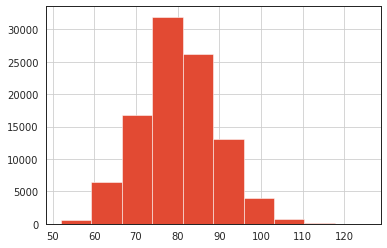

In [178]:
df_sample['허리둘레'].sort_values().hist()

#### 3-7-4. 수치형 변수 Transformations 
 - num_ln_target_features --- 로그를 취할 변수명 list(추후 최종 입력 전 삭제 필요)

 - num_ln_cols --- 로그를 취하고 난 뒤의 변수명 list

In [179]:
# 수치형 변수들에 log를 취한 값 산출
# 로그 취할 대상 컬럼 선정 # 그리고 log를 취한 원 변수는 추후에 버릴 예정으로 따로 기록해 둔다
num_ln_target_features = ['LDL콜레스테롤', 'HDL콜레스테롤', '시력좌', '시력우', '혈청크레아티닌', '혈청지오티AST','혈청지오티ALT', '감마지티피', '트리글리세라이드', '식전혈당공복혈당']

# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_ln_cols = list(map(lambda x: str(x)+"_LN", num_ln_target_features))

num_pipeline = Pipeline([
        ('log_scaler', FunctionTransformer(np.log1p, validate=True)), # pipeline 내 log transformation을 위해 Function Transfomer 사용
        ('normalizer', MinMaxScaler()),
    ])

piped_np = num_pipeline.fit_transform(df_sample[num_ln_target_features])
piped_df = pd.DataFrame(piped_np, columns=num_ln_cols)

print(len(piped_df))
piped_df.head()

100000


,LDL콜레스테롤_LN,HDL콜레스테롤_LN,시력좌_LN,시력우_LN,혈청크레아티닌_LN,혈청지오티AST_LN,혈청지오티ALT_LN,감마지티피_LN,트리글리세라이드_LN,식전혈당공복혈당_LN
0,0.516085,0.506974,0.260671,0.238306,0.111812,0.357485,0.293662,0.364987,0.602007,0.308176
1,0.580028,0.540646,0.302229,0.302229,0.135733,0.516340,0.486838,0.265176,0.483866,0.311479
2,0.577278,0.396808,0.302229,0.260671,0.124088,0.434763,0.426570,0.462302,0.582812,0.342781
3,0.541243,0.493089,0.135235,0.135235,0.085071,0.457840,0.360116,0.238640,0.381989,0.242161
4,0.651730,0.543432,0.214731,0.214731,0.098835,0.347358,0.377384,0.308438,0.423212,0.311479


#### 3-7-6. 수치형 LN 변수 count plot (단변량)

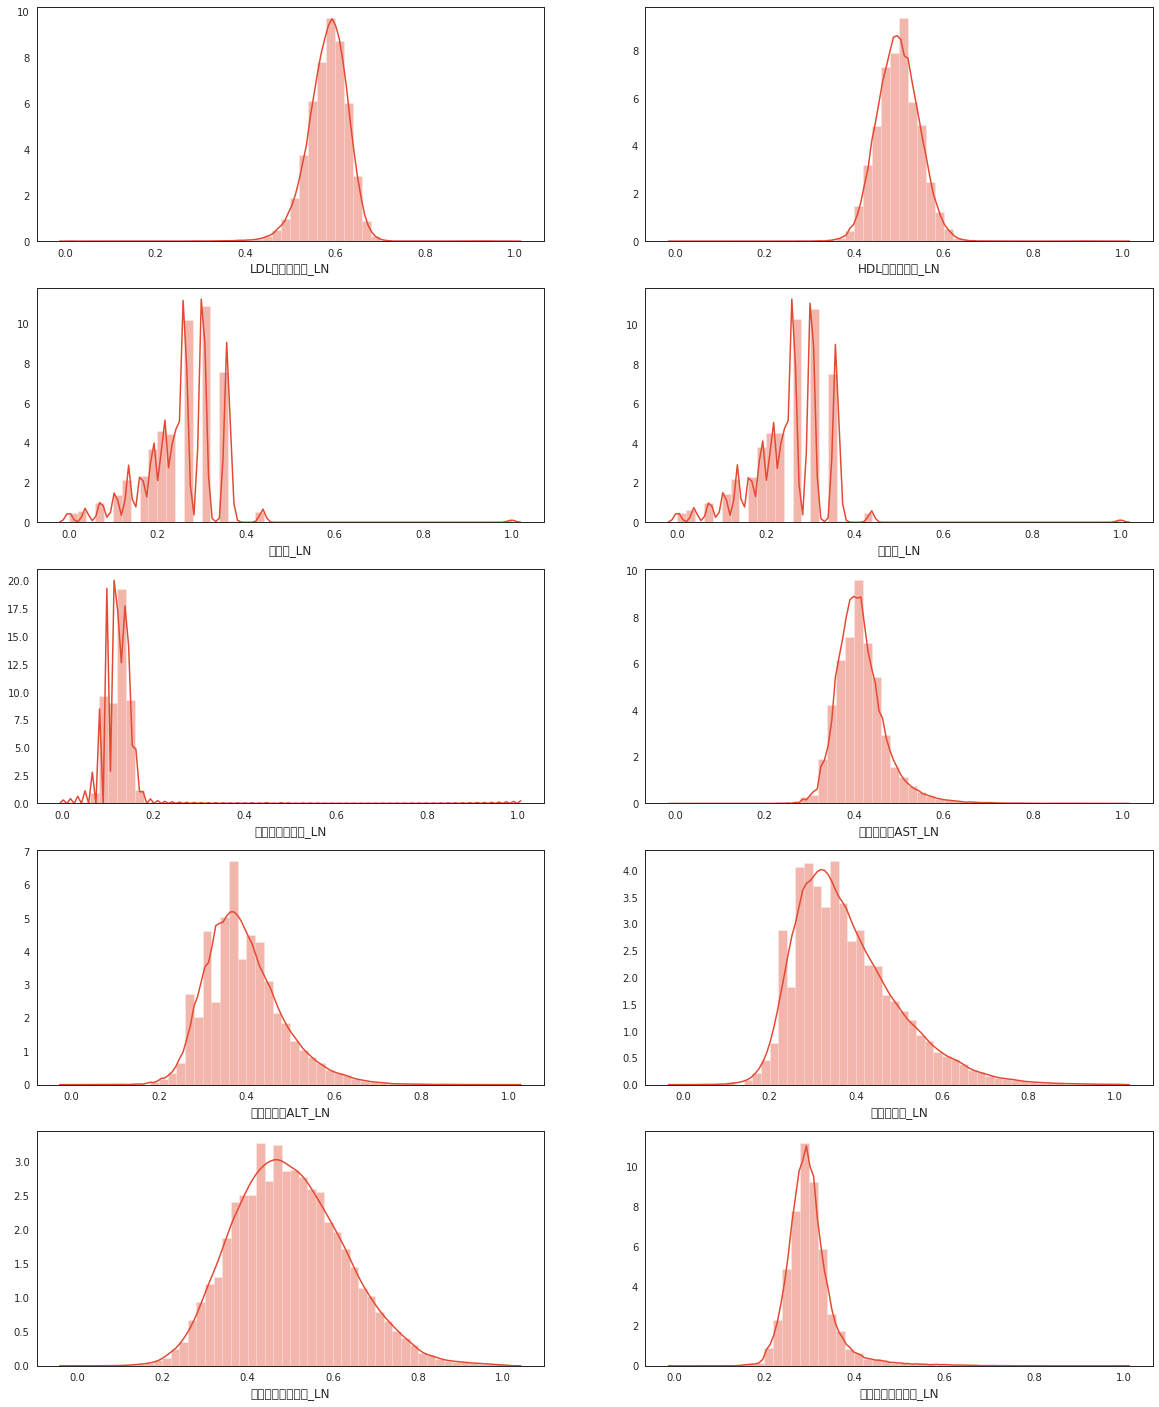

<Figure size 432x288 with 0 Axes>

In [180]:
# 단변수 탐색 with log 변형 변수
fig, saxis = plt.subplots(5, 2, figsize=(20,25))
plt.figure()

# 변수별로 for문을 돌면서 distplot 그림
for idx, col in enumerate(num_ln_cols):
    row_loc = idx // 2
    col_loc = idx % 2
    # print(idx, row_loc, col_loc)
    sns.distplot(piped_df.loc[piped_df[col].notnull(), col], ax = saxis[row_loc,col_loc])

plt.show()

#### 3-7-5. 로그 취한 수치형 변수 Concat을 통한 새 Dataframe 생성 

In [181]:
print("Before Re-indexing: Data count is ", len(df_sample))
df_sample.drop_duplicates()
df_sample.reset_index(inplace=True, drop=True)
print("After Re-indexing: Data count is ", len(df_sample))

df_fe = pd.concat([df_sample, piped_df], axis=1)
df_fe.head()

Before Re-indexing: Data count is  100000
After Re-indexing: Data count is  100000


,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,A_성별,A_연령대5세단위,A_시도,A_청력좌,A_청력우,A_요단백,A_흡연상태,A_음주여부,LDL콜레스테롤_LN,HDL콜레스테롤_LN,시력좌_LN,시력우_LN,혈청크레아티닌_LN,혈청지오티AST_LN,혈청지오티ALT_LN,감마지티피_LN,트리글리세라이드_LN,식전혈당공복혈당_LN
0,155,55,71,1.0,0.9,120,80,97,158,171,56,68.0,13.3,0.8,16,11,24,0.0,1.0,0.0,0.0,1.0,여,40,서울,정상,정상,음성,비흡연,음주,0.516085,0.506974,0.260671,0.238306,0.111812,0.357485,0.293662,0.364987,0.602007,0.308176
1,165,60,78,1.2,1.2,120,80,98,193,101,67,106.0,15.0,1.0,43,38,13,0.0,0.0,0.0,1.0,1.0,남,30,경기,정상,정상,음성,금연,음주,0.580028,0.540646,0.302229,0.302229,0.135733,0.516340,0.486838,0.265176,0.483866,0.311479
2,180,85,87,1.2,1.0,126,86,108,166,157,31,104.0,16.3,0.9,26,26,43,0.0,0.0,0.0,0.0,0.0,남,30,경북,정상,정상,음성,흡연,음주,0.577278,0.396808,0.302229,0.260671,0.124088,0.434763,0.426570,0.462302,0.582812,0.342781
3,160,50,66,0.5,0.5,119,78,79,150,64,52,81.0,12.9,0.6,30,17,11,0.0,0.0,0.0,0.0,0.0,여,25,인천,정상,정상,음성,비흡연,비음주,0.541243,0.493089,0.135235,0.135235,0.085071,0.457840,0.360116,0.238640,0.381989,0.242161
4,145,50,74,0.8,0.8,110,70,98,258,77,68,174.0,12.8,0.7,15,19,17,0.0,0.0,0.0,0.0,0.0,여,60,부산,정상,정상,음성,비흡연,비음주,0.651730,0.543432,0.214731,0.214731,0.098835,0.347358,0.377384,0.308438,0.423212,0.311479


In [182]:
import gc
gc.collect()

168

### 3-8. Information Value 계산을 위한 환경 세팅

### 3-8-1. woe library 설치

In [183]:
# woe package install
! pip install woe

### 3-8-2. Library Load 및 환경 변수 세팅

In [0]:
# Calculate IV Setting
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string
import woe
from woe.eval import plot_ks

max_bin = 10
force_bin = 3

### 3-8-3. Information Value 산출 사용자 정의 함수 정의

In [0]:
# Define a binning function for continous independent variables
def mono_bin(Y, X, n = max_bin):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]
  r = 0
    
  while np.abs(r) < 1:
    try:
      global d1
      global d2
      d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
      d2 = d1.groupby('Bucket', as_index=True)
      r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
      n = n - 1 
    except Exception as e:
      n = n - 1
      break
      
  if len(d2) == 1:
    n = force_bin         
    bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
    if len(np.unique(bins)) == 2:
        bins = np.insert(bins, 0, 1)
        bins[1] = bins[1]-(bins[1]/2)
    d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
    d2 = d1.groupby('Bucket', as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["MIN_VALUE"] = d2.min().X
  d3["MAX_VALUE"] = d2.max().X
  d3["COUNT"] = d2.count().Y
  d3["EVENT"] = d2.sum().Y
  d3["NONEVENT"] = d2.count().Y - d2.sum().Y
  d3=d3.reset_index(drop=True)

  if len(justmiss.index) > 0:
      d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
      d4["MAX_VALUE"] = np.nan
      d4["COUNT"] = justmiss.count().Y
      d4["EVENT"] = justmiss.sum().Y
      d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
      d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()

  return(d3)
  
# Define a binning function for categorical independent variables
def char_bin(Y, X):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]    
  df2 = notmiss.groupby('X',as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["COUNT"] = df2.count().Y
  d3["MIN_VALUE"] = df2.sum().Y.index
  d3["MAX_VALUE"] = d3["MIN_VALUE"]
  d3["EVENT"] = df2.sum().Y
  d3["NONEVENT"] = df2.count().Y - df2.sum().Y

  if len(justmiss.index) > 0:
    d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
    d4["MAX_VALUE"] = np.nan
    d4["COUNT"] = justmiss.count().Y
    d4["EVENT"] = justmiss.sum().Y
    d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
    d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()
  d3 = d3.reset_index(drop=True)

  return(d3)

# Calculate Information Values
def calc_iv_all(df1, target):
    
  stack = traceback.extract_stack()
  filename, lineno, function_name, code = stack[-2]
  vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
  final = (re.findall(r"[\w']+", vars_name))[-1]

  x = df1.dtypes.index
  count = -1

  for i in tqdm_notebook(x):
    if i.upper() not in (final.upper()):
      if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
        conv = mono_bin(target, df1[i])
        conv["VAR_NAME"] = i
        count = count + 1
      else:
        conv = char_bin(target, df1[i])
        conv["VAR_NAME"] = i            
        count = count + 1

      if count == 0:
        iv_df = conv
      else:
        iv_df = iv_df.append(conv,ignore_index=True)

  iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
  iv = iv.reset_index()
  return(iv_df,iv)

### 3-8-4. IV 산출을 위한 data sampling 및 IV 산출

In [0]:
# Information Value Test를 위한 임시 Dataframe 생성
need_cols = list(set(df_fe.columns) - (set(num_ln_target_features + remove_target_candidates) - set([target_nm])))

df_iv_test = df_fe[need_cols].copy()

In [187]:
# IV 산출
first_iv_df, IV_first = calc_iv_all(df_iv_test,df_iv_test[target_nm])
# first_iv_df

# IV 값 내림차순 정렬
IV_first.sort_values('IV',ascending=False)

,VAR_NAME,IV
2,A_연령대5세단위,0.075370
7,A_흡연상태,0.055330
1,A_시도,0.030433
15,신장5Cm단위,0.018080
0,A_성별,0.013931
17,체중5Kg단위,0.010495
22,혈색소,0.010254
4,A_음주여부,0.009452
16,이완기혈압,0.005650
10,감마지티피_LN,0.005632


## 4. Feature Engineering

### 4-1. Feature Engineering 내부 변수 추가
- 데이터셋 내 내부 변수의 범주화를 통한 신규 변수 추출

In [0]:
# 기존 수치형 변수들을 LN 변수들로 치환
# df_fe.drop(columns=numeric_feature, axis=1, inplace=True)

# BMI 변수 추가
df_fe["A_BMI"] = (df_fe["체중5Kg단위"]/(df_fe["신장5Cm단위"]*df_fe["신장5Cm단위"])).astype(float)

# 공복 혈당 
# 100 이하는 정상/ 100 ~ 125는 '공복혈당장애 - 당뇨 전단계'/ 125 이상은 당뇨
# 당뇨병의 중간인 100~125 mg/dL가 나오거나 

df_fe["A_diabetes"] = np.where(df_fe['식전혈당공복혈당'].between(0, 100, inclusive=True), '정상', 
                               np.where(df_fe['식전혈당공복혈당'].between(100, 124.9, inclusive=True), '당뇨전단계', 
                                        '당뇨')
                              )

# HDL 콜레스테롤
# HDL 콜레스테롤 수치가 남자에서 40 mg/dL (1.0 mmol/L) 이하 또는 여자에서 50 mg/dL (1.3 mmol/L) 이하일 경우에는 다른 위험인자와 독립적으로 심장 질환의 위험도가 증가
# HDL 콜레스테롤 수치가 남자에서 40-50 mg/dL (1.0-1.3 mmol/L) 그리고 여자에서 50-59 mg/dL (1.3-1.5 mmol/L)인 경우에는 심장 질환의 평균위험도와 연관
# 보통 HDL 콜레스테롤 수치가 60 mg/dL (1.55 mmol/L) 또는 그 이상일 경우에는 심장 질환 평균 위험도보다 낮음
# National Cholesterol Education Panel Adult Treatment Guidelines에 따르면 HDL 콜레스테롤 수치가 60 mg/dL 이상일 경우 심장 질환에서 보호되고 음성 위험 인자로서 치료되어야 함
df_fe["A_HDL"] = np.where(
                    (df_fe['A_성별'] == "여") & (df_fe['HDL콜레스테롤']<= 50), '고위험', 
                       np.where(
                         (df_fe['A_성별']== "여") & (df_fe['HDL콜레스테롤'].between(50, 59.9, inclusive=True)), '위험', 
                           np.where(
                               (df_fe['A_성별']== "남") & (df_fe['HDL콜레스테롤']<= 40), '고위험', 
                                      np.where(
                                          (df_fe['A_성별']== "남") & (df_fe['HDL콜레스테롤'].between(40, 49.9, inclusive=True)), '위험', '정상')
                          )))
# LDL 콜레스테롤(혈중 모든 콜레스테롤 중 LDL 콜레스테롤이 심장질환에 대한 위험도를 확인하는데 가장 중요한 지표)
# 대부분의 치료 결정이 LDL 수치를 토대로 이루어지기 때문에 이 검사를 통해 식이요법 또는 운동처방의 효과를 감시하거나 지질감소 약물을 처방하는 것이 유용한지에 대한 평가
# 100 mg/dL (2.59mmol/L) 미만 – 최적
# 100-129 mg/dL (2.59-3.34 mmol/L) – 최적에 인접
# 130-159 mg/dL (3.37-4.12 mmol/L) – 상한 경계성
# 160-189 mg/dL (4.15-4.90 mmol/L) – 높음
# 190 mg/dL (4.90 mmol) 이상 – 매우 높음
df_fe["A_LDL"] = np.where(df_fe['LDL콜레스테롤']<100, '최적', 
                    np.where(df_fe['LDL콜레스테롤'].between(100, 122.9, inclusive=True), '최적인접', 
                             np.where(df_fe['LDL콜레스테롤'].between(130, 159.9, inclusive=True), '상한경계', 
                                      np.where(df_fe['LDL콜레스테롤'].between(160, 189.9, inclusive=True), '높음', '매우높음')
                              )))

# 트리글리세라이드
# 지방의 한 형태로서 몸의 주요 에너지원, 트리글리세라이드가 증가하는 것은, 이유가 분명하지 않으나 심혈관 질환으로 진행될 위험의 증가와 관련
# 일부 인자들 즉, 운동 부족, 과체중, 흡연, 과음 및 당뇨와 신질환 등의 질병 상태가 고트리글리세라이드혈증 및 심혈관 질환 위험도 증가에 기여할 수 있음
# 성인에서는 트리글리세라이드 결과가 아래와 같이 나뉘어진다.
# 150 mg/dL (1.7 mmol/L) 미만: 바람직
# 150-199 mg/dL (1.7-2.2 mmol/L): 경계성증가
# 200-499 mg/dL (2.3-5.6 mmol/L): 증가: 
# 500 mg/dL (5.6 mmol/L) 이상: 매우 증가
# 이 수치는 공복시 트리글리세라이드 수치에 기준합니다.
df_fe["A_TRI"] = np.where(df_fe['트리글리세라이드']<150, '바람직', 
                    np.where(df_fe['트리글리세라이드'].between(150, 199.9, inclusive=True), '경계성증가', 
                             np.where(df_fe['트리글리세라이드'].between(200, 499.9, inclusive=True), '증가', '매우증가')
                              ))

# 혈색소
# 성인의 데시리터(100밀리리터) 당 12그램에서 18그램 정도: 정상치
# 18그램 이상: 폐질환 등 기타 이상
# 12그램 미만: 빈혈
df_fe["A_HEMO"] = np.where(df_fe['혈색소'].between(12, 17.9, inclusive=True), '정상', 
                    np.where(df_fe['혈색소']>=18, '이상', '빈혈'))

# 요단백: 소변으로 빠져나가는 잉여의 단백질을 검출하기 위해, 신장 기증을 평가하고 모니터하는 것을 돕기 위해,  그리고 신장 손상을 검출하기 위해 검사
# 요단백은 보통 소변에서 검출 되지 않음

# 혈중 크레아티닌 농도의 
# 정상범위는 0.50~1.4 mg/dL 입니다
# 근육량에 비례하는 검사결과이므로 여성보다는 남성에게서 약간 높은 수치가 나타나고, 식사나 운동이 결과에 영향이 거의 미치지 않습니다. 지속적으로 많은 양의 육식을 섭취한 경우에는 크레아티닌 농도가 높게 측정됩니다.
df_fe["A_CRE"] = np.where(df_fe['혈청크레아티닌'].between(0.5, 1.4, inclusive=True), '정상', '이상')

# 혈청지오티AST:
#  간기능을 평가하는 기초검사항목으로서 알코올성 간장애나 만성 간질환에서 주로 증가한다.
 

# 혈청지오티ALT:
# 간기능을 평가하는 기초검사항목으로서 급성 간염 시 주로 증가한다.
# 증가: 간질환, 심근경색, 지방간, 비만


# 감마지티피
# 간장세포나 담낭세포가 파괴되면 감마지티피가 혈액속으로 누출되어 수치가 높아짐
# 남자는 50IU 이하, 여자는 32IU이하가 정상
# 100이하면 음주 조절을 통해 조정 가능하나 100 이상이면 지방간이 진행되고 있을 가능성이 높음
# 200 이상이면 담석이나 담도암등으로 담도가 막혀있을 가능성이 높음
# 500 이상이면 황달
df_fe["A_GTP"] = np.where((df_fe['감마지티피'] >= 500), '황달', 
                       np.where(df_fe['감마지티피']>=200, '담도이상', 
                           np.where(df_fe['감마지티피']>= 100, '이상가능', 
                             np.where((df_fe['A_성별']== "남") & (df_fe['감마지티피']<=50), '정상',
                              np.where((df_fe['A_성별']== "여") & (df_fe['감마지티피']<=32), '정상', '체크')
                          ))))

In [189]:
df_fe.head(2)

,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,A_성별,A_연령대5세단위,A_시도,A_청력좌,A_청력우,A_요단백,A_흡연상태,A_음주여부,LDL콜레스테롤_LN,HDL콜레스테롤_LN,시력좌_LN,시력우_LN,혈청크레아티닌_LN,혈청지오티AST_LN,혈청지오티ALT_LN,감마지티피_LN,트리글리세라이드_LN,식전혈당공복혈당_LN,A_BMI,A_diabetes,A_HDL,A_LDL,A_TRI,A_HEMO,A_CRE,A_GTP
0,155,55,71,1.0,0.9,120,80,97,158,171,56,68.0,13.3,0.8,16,11,24,0.0,1.0,0.0,0.0,1.0,여,40,서울,정상,정상,음성,비흡연,음주,0.516085,0.506974,0.260671,0.238306,0.111812,0.357485,0.293662,0.364987,0.602007,0.308176,0.002289,정상,위험,최적,경계성증가,정상,정상,정상
1,165,60,78,1.2,1.2,120,80,98,193,101,67,106.0,15.0,1.0,43,38,13,0.0,0.0,0.0,1.0,1.0,남,30,경기,정상,정상,음성,금연,음주,0.580028,0.540646,0.302229,0.302229,0.135733,0.516340,0.486838,0.265176,0.483866,0.311479,0.002204,정상,정상,최적인접,바람직,정상,정상,정상


### 4-2. Feature Engineering 외부 변수 추가
- 외부 데이터 및 변수를 통한 신규 변수 추출

### 4-2-1. 데이터셋 외부 변수 load 및 검증

In [190]:
!ls /gdrive/My\ Drive/

'Getting started.pdf'   sds


In [191]:
df_add1 = pd.read_csv('../gdrive/My Drive/sds/data/구강검진결과_14년도_작업완료.csv', encoding = 'euc-kr')
df_add1["성별"] = df_add1["성별"].str[:1]
df_add2 = pd.read_csv('../gdrive/My Drive/sds/data/KOSIS 연령별 성별 치과 평균 수진횟수 2014.csv', encoding = 'euc-kr')
df_add2.dropna(axis=0, inplace=True)
display(df_add1.info())
display(df_add2.info())
display(df_add1.head())
display(df_add2.head())

# KOSIS 연령별 성별 치과 평균 수진횟수 2014

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 14 columns):
시도             34 non-null object
성별             34 non-null object
n_정상A_결과       34 non-null float64
n_정상B_결과       34 non-null float64
n_주의_결과        34 non-null float64
n_치료필요_결과      34 non-null float64
n_기타_결과        34 non-null float64
n_영양_교육        34 non-null float64
n_위생_교육        34 non-null float64
n_불소_교육        34 non-null float64
n_정밀검진_권고      34 non-null float64
n_관리_권고        34 non-null float64
n_우식필요_권고      34 non-null float64
n_치주치료필요_권고    34 non-null float64
dtypes: float64(12), object(2)
memory usage: 3.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 3 columns):
연령대코드5세단위     28 non-null float64
성별            28 non-null object
n_치과평균수진횟수    28 non-null float64
dtypes: float64(2), object(1)
memory usage: 896.0+ bytes


None

,시도,성별,n_정상A_결과,n_정상B_결과,n_주의_결과,n_치료필요_결과,n_기타_결과,n_영양_교육,n_위생_교육,n_불소_교육,n_정밀검진_권고,n_관리_권고,n_우식필요_권고,n_치주치료필요_권고
0,서울,남,0.0055,0.0211,0.0350,0.0416,0.0,0.1085,0.1076,0.1098,0.1174,0.1044,0.0997,0.1072
1,서울,여,0.0051,0.0248,0.0299,0.0297,0.0,0.0860,0.0901,0.0927,0.0944,0.0915,0.0701,0.0667
2,부산,남,0.0017,0.0074,0.0102,0.0188,0.0,0.0376,0.0387,0.0398,0.0384,0.0386,0.0460,0.0464
3,부산,여,0.0015,0.0079,0.0078,0.0123,0.0,0.0223,0.0292,0.0293,0.0274,0.0305,0.0293,0.0258
4,대구,남,0.0009,0.0043,0.0064,0.0074,0.0,0.0194,0.0199,0.0206,0.0178,0.0194,0.0181,0.0160


,연령대코드5세단위,성별,n_치과평균수진횟수
0,20.0,남,67.19
1,20.0,여,110.27
2,25.0,남,74.29
3,25.0,여,98.40
4,30.0,남,65.03


In [192]:
df_fe['A_연령대5세단위'].value_counts()

40    15272
30    14016
50    12103
45    11038
25    10695
35    10474
55     8235
60     6173
20     3886
65     3481
70     3125
75     1072
80      371
85       59
Name: A_연령대5세단위, dtype: int64

### 4-2-2. 데이터셋 외부 변수 결합


In [193]:
# Multiple Key를 사용하여 Join
# left_on=['column_name1','column_name2'], right_on = ['column_name3','column_name4']
print(len(df_fe))

df_new = pd.merge(left=df_fe, right=df_add1, how='outer', left_on=['A_시도','A_성별'], right_on = ['시도','성별'], sort=False)
df_new.drop(columns=['시도','성별'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add2, how='outer', left_on=['A_연령대5세단위','A_성별'], right_on = ['연령대코드5세단위','성별'], sort=False)
df_new.drop(columns=['연령대코드5세단위','성별'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

display(df_new.info())

100000


,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,A_성별,A_연령대5세단위,A_시도,A_청력좌,A_청력우,A_요단백,A_흡연상태,A_음주여부,LDL콜레스테롤_LN,HDL콜레스테롤_LN,시력좌_LN,시력우_LN,혈청크레아티닌_LN,혈청지오티AST_LN,혈청지오티ALT_LN,감마지티피_LN,트리글리세라이드_LN,식전혈당공복혈당_LN,A_BMI,A_diabetes,A_HDL,A_LDL,A_TRI,A_HEMO,A_CRE,A_GTP,n_정상A_결과,n_정상B_결과,n_주의_결과,n_치료필요_결과,n_기타_결과,n_영양_교육,n_위생_교육,n_불소_교육,n_정밀검진_권고,n_관리_권고,n_우식필요_권고,n_치주치료필요_권고
0,155,55,71,1.0,0.9,120,80,97,158,171,56,68.0,13.3,0.8,16,11,24,0.0,1.0,0.0,0.0,1.0,여,40,서울,정상,정상,음성,비흡연,음주,0.516085,0.506974,0.260671,0.238306,0.111812,0.357485,0.293662,0.364987,0.602007,0.308176,0.002289,정상,위험,최적,경계성증가,정상,정상,정상,0.0051,0.0248,0.0299,0.0297,0.0,0.086,0.0901,0.0927,0.0944,0.0915,0.0701,0.0667
1,155,50,72,1.5,1.5,107,61,82,178,32,66,106.0,13.8,0.6,14,8,12,0.0,0.0,0.0,0.0,0.0,여,30,서울,정상,정상,음성,비흡연,비음주,0.580028,0.537819,0.357967,0.357967,0.085071,0.336577,0.246512,0.252419,0.228722,0.254136,0.002081,정상,정상,최적인접,바람직,정상,정상,정상,0.0051,0.0248,0.0299,0.0297,0.0,0.086,0.0901,0.0927,0.0944,0.0915,0.0701,0.0667
2,155,50,68,0.5,0.6,150,100,120,212,154,50,131.0,12.9,0.9,16,12,18,0.0,0.0,1.0,0.0,1.0,여,45,서울,정상,정상,음성,비흡연,비음주,0.610631,0.485749,0.135235,0.163375,0.124088,0.357485,0.306780,0.317745,0.578478,0.376755,0.002081,당뇨전단계,고위험,상한경계,경계성증가,정상,정상,정상,0.0051,0.0248,0.0299,0.0297,0.0,0.086,0.0901,0.0927,0.0944,0.0915,0.0701,0.0667
3,150,50,75,0.9,1.2,104,59,98,259,96,56,184.0,13.1,0.4,27,27,15,0.0,0.0,0.0,0.0,0.0,여,50,서울,정상,정상,음성,비흡연,비음주,0.659829,0.506974,0.238306,0.302229,0.054754,0.440838,0.432530,0.288162,0.472502,0.311479,0.002222,정상,위험,높음,바람직,정상,이상,정상,0.0051,0.0248,0.0299,0.0297,0.0,0.086,0.0901,0.0927,0.0944,0.0915,0.0701,0.0667
4,145,50,72,0.9,0.8,136,89,102,194,207,48,104.0,13.1,0.8,24,18,26,0.0,0.0,0.0,0.0,0.0,여,70,서울,정상,정상,음성,비흡연,비음주,0.577278,0.478115,0.238306,0.214731,0.111812,0.421907,0.368977,0.378236,0.644976,0.324363,0.002378,당뇨전단계,고위험,최적인접,증가,정상,정상,정상,0.0051,0.0248,0.0299,0.0297,0.0,0.086,0.0901,0.0927,0.0944,0.0915,0.0701,0.0667


100000


,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,A_성별,A_연령대5세단위,A_시도,A_청력좌,A_청력우,A_요단백,A_흡연상태,A_음주여부,LDL콜레스테롤_LN,HDL콜레스테롤_LN,시력좌_LN,시력우_LN,혈청크레아티닌_LN,혈청지오티AST_LN,혈청지오티ALT_LN,감마지티피_LN,트리글리세라이드_LN,식전혈당공복혈당_LN,A_BMI,A_diabetes,A_HDL,A_LDL,A_TRI,A_HEMO,A_CRE,A_GTP,n_정상A_결과,n_정상B_결과,n_주의_결과,n_치료필요_결과,n_기타_결과,n_영양_교육,n_위생_교육,n_불소_교육,n_정밀검진_권고,n_관리_권고,n_우식필요_권고,n_치주치료필요_권고,n_치과평균수진횟수
0,155,55,71,1.0,0.9,120,80,97,158,171,56,68.0,13.3,0.8,16,11,24,0.0,1.0,0.0,0.0,1.0,여,40,서울,정상,정상,음성,비흡연,음주,0.516085,0.506974,0.260671,0.238306,0.111812,0.357485,0.293662,0.364987,0.602007,0.308176,0.002289,정상,위험,최적,경계성증가,정상,정상,정상,0.0051,0.0248,0.0299,0.0297,0.0,0.086,0.0901,0.0927,0.0944,0.0915,0.0701,0.0667,49.46
1,160,50,75,0.8,0.8,100,60,108,216,84,68,131.0,10.7,0.8,16,9,10,0.0,0.0,1.0,0.0,1.0,여,40,서울,정상,정상,음성,비흡연,음주,0.610631,0.543432,0.214731,0.214731,0.111812,0.357485,0.263780,0.223662,0.442643,0.342781,0.001953,당뇨전단계,정상,상한경계,바람직,빈혈,정상,정상,0.0051,0.0248,0.0299,0.0297,0.0,0.086,0.0901,0.0927,0.0944,0.0915,0.0701,0.0667,49.46
2,155,80,99,1.2,1.2,130,90,128,202,167,48,121.0,13.4,1.0,76,122,39,0.0,0.0,0.0,0.0,0.0,여,40,서울,정상,정상,음성,비흡연,음주,0.599149,0.478115,0.302229,0.302229,0.135733,0.609820,0.675093,0.445895,0.596687,0.397581,0.003330,당뇨,고위험,최적인접,경계성증가,정상,정상,체크,0.0051,0.0248,0.0299,0.0297,0.0,0.086,0.0901,0.0927,0.0944,0.0915,0.0701,0.0667,49.46
3,155,60,80,0.6,1.0,104,60,101,156,67,62,81.0,12.4,0.9,19,15,13,0.0,0.0,0.0,0.0,1.0,여,40,서울,정상,정상,음성,비흡연,음주,0.541243,0.526072,0.163375,0.260671,0.124088,0.384633,0.340812,0.265176,0.392191,0.321190,0.002497,당뇨전단계,정상,최적,바람직,정상,정상,정상,0.0051,0.0248,0.0299,0.0297,0.0,0.086,0.0901,0.0927,0.0944,0.0915,0.0701,0.0667,49.46
4,160,55,66,0.8,0.9,107,63,78,204,134,42,135.0,15.3,0.6,18,16,24,0.0,0.0,0.0,0.0,0.0,여,40,서울,정상,정상,양성,흡연,비음주,0.614982,0.453190,0.214731,0.238306,0.085071,0.376064,0.350748,0.364987,0.547242,0.238069,0.002148,정상,고위험,상한경계,바람직,정상,정상,정상,0.0051,0.0248,0.0299,0.0297,0.0,0.086,0.0901,0.0927,0.0944,0.0915,0.0701,0.0667,49.46


100000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 61 columns):
신장5Cm단위        100000 non-null object
체중5Kg단위        100000 non-null object
허리둘레           100000 non-null int64
시력좌            100000 non-null float64
시력우            100000 non-null float64
수축기혈압          100000 non-null int64
이완기혈압          100000 non-null int64
식전혈당공복혈당       100000 non-null int64
총콜레스테롤         100000 non-null int64
트리글리세라이드       100000 non-null int64
HDL콜레스테롤       100000 non-null int64
LDL콜레스테롤       100000 non-null float64
혈색소            100000 non-null float64
혈청크레아티닌        100000 non-null float64
혈청지오티AST       100000 non-null int64
혈청지오티ALT       100000 non-null int64
감마지티피          100000 non-null int64
치아우식증유무        100000 non-null float64
결손치유무          100000 non-null float64
치아마모증유무        100000 non-null float64
제3대구치사랑니이상     100000 non-null float64
치석             100000 non-null float64
A_성별           100000 non-null object
A_연령대5세단위

None

#### 4-1-4. 데이터셋 내 내부 변수 신규 변수 검증(To-Do)

### 4-2. FE 추가변수 IV값 산출

In [0]:
# Information Value Test를 위한 임시 Dataframe 생성
need_cols = list(set(df_new.columns) - (set(num_ln_target_features + remove_target_candidates) - set([target_nm])))
df_iv_final = df_new[need_cols].copy()

In [195]:
fe_iv_df, IV_fe = calc_iv_all(df_iv_final,df_iv_final[target_nm])
# fe_iv_df

# IV 값 내림차순 정렬
IV_fe.sort_values('IV',ascending=False)

,VAR_NAME,IV
10,A_연령대5세단위,0.075370
15,A_흡연상태,0.055330
9,A_시도,0.030433
36,신장5Cm단위,0.018080
8,A_성별,0.013931
38,체중5Kg단위,0.010495
22,n_우식필요_권고,0.010254
43,혈색소,0.010254
12,A_음주여부,0.009452
37,이완기혈압,0.005650


### 4-3. Feature Engineering 이전과 Feature Engineering 이후의 IV 값 비교

In [196]:
IV_compare = pd.merge(IV_fe, IV_first, how='outer', on="VAR_NAME")
IV_compare = IV_compare.reset_index(drop=True)
IV_compare.sort_values(['IV_x'], ascending=False)

,VAR_NAME,IV_x,IV_y
10,A_연령대5세단위,0.075370,0.075370
15,A_흡연상태,0.055330,0.055330
9,A_시도,0.030433,0.030433
36,신장5Cm단위,0.018080,0.018080
8,A_성별,0.013931,0.013931
38,체중5Kg단위,0.010495,0.010495
22,n_우식필요_권고,0.010254,NaN
43,혈색소,0.010254,0.010254
12,A_음주여부,0.009452,0.009452
37,이완기혈압,0.005650,0.005650


In [197]:
IV_input_col = list(IV_compare[IV_compare['IV_x']>0.01]['VAR_NAME'])
IV_input_col

['A_성별',
 'A_시도',
 'A_연령대5세단위',
 'A_흡연상태',
 'n_우식필요_권고',
 '신장5Cm단위',
 '체중5Kg단위',
 '혈색소']

### 4-4. 수치형 변수 기준 상관계수 체크

In [198]:
# 상관계수 검증을 위한 연속형 변수 탐색
num_features_after_fe = [col for col in df_iv_final.columns if df_iv_final[col].dtypes != "object"]
num_features_after_fe = np.sort(num_features_after_fe)

num_input = list(set(num_features_after_fe) - set(remove_target_candidates))
print(num_input)

print(len(num_input)) # 총 26개

['n_위생_교육', 'n_정밀검진_권고', 'n_불소_교육', 'n_치주치료필요_권고', '트리글리세라이드_LN', 'n_주의_결과', 'n_치과평균수진횟수', '시력좌_LN', '허리둘레', 'n_정상B_결과', '시력우_LN', '혈청지오티ALT_LN', '혈청지오티AST_LN', '혈청크레아티닌_LN', 'LDL콜레스테롤_LN', '혈색소', 'n_우식필요_권고', 'A_BMI', 'n_기타_결과', '식전혈당공복혈당_LN', '총콜레스테롤', 'HDL콜레스테롤_LN', 'n_관리_권고', 'n_영양_교육', '이완기혈압', '수축기혈압', 'n_치료필요_결과', 'n_정상A_결과', '감마지티피_LN']
29


In [199]:
from pprint import pprint as pp

corr_dict = {}

for i in num_input:
    corr_dict[i] = df_iv_final[target_nm].astype('float64').corr(df_iv_final[i])

pp(corr_dict)

{'A_BMI': 0.014226159755167616,
 'HDL콜레스테롤_LN': -0.006015094977761996,
 'LDL콜레스테롤_LN': -0.028962031511659995,
 'n_관리_권고': 0.002081492232160533,
 'n_기타_결과': nan,
 'n_불소_교육': 0.0031076447024755375,
 'n_영양_교육': 0.008787077542072207,
 'n_우식필요_권고': 0.013819979305229371,
 'n_위생_교육': 0.0038647155287291706,
 'n_정밀검진_권고': 0.00458670323754168,
 'n_정상A_결과': -0.008982850426918182,
 'n_정상B_결과': -0.015772225624840788,
 'n_주의_결과': 0.001227969837667911,
 'n_치과평균수진횟수': -0.010015925773034322,
 'n_치료필요_결과': 0.013044660719811073,
 'n_치주치료필요_권고': 0.01732877496086799,
 '감마지티피_LN': 0.04008843321974448,
 '수축기혈압': 0.012548712407102978,
 '시력우_LN': 0.022885648785077824,
 '시력좌_LN': 0.025491357708855734,
 '식전혈당공복혈당_LN': -0.013736094254549313,
 '이완기혈압': 0.02040185265646016,
 '총콜레스테롤': -0.02540089646335065,
 '트리글리세라이드_LN': 0.013461975655022907,
 '허리둘레': 0.014402402488718352,
 '혈색소': 0.04243643899068369,
 '혈청지오티ALT_LN': 0.018717971633267362,
 '혈청지오티AST_LN': 0.0019556540960981054,
 '혈청크레아티닌_LN': 0.002190524375176581}


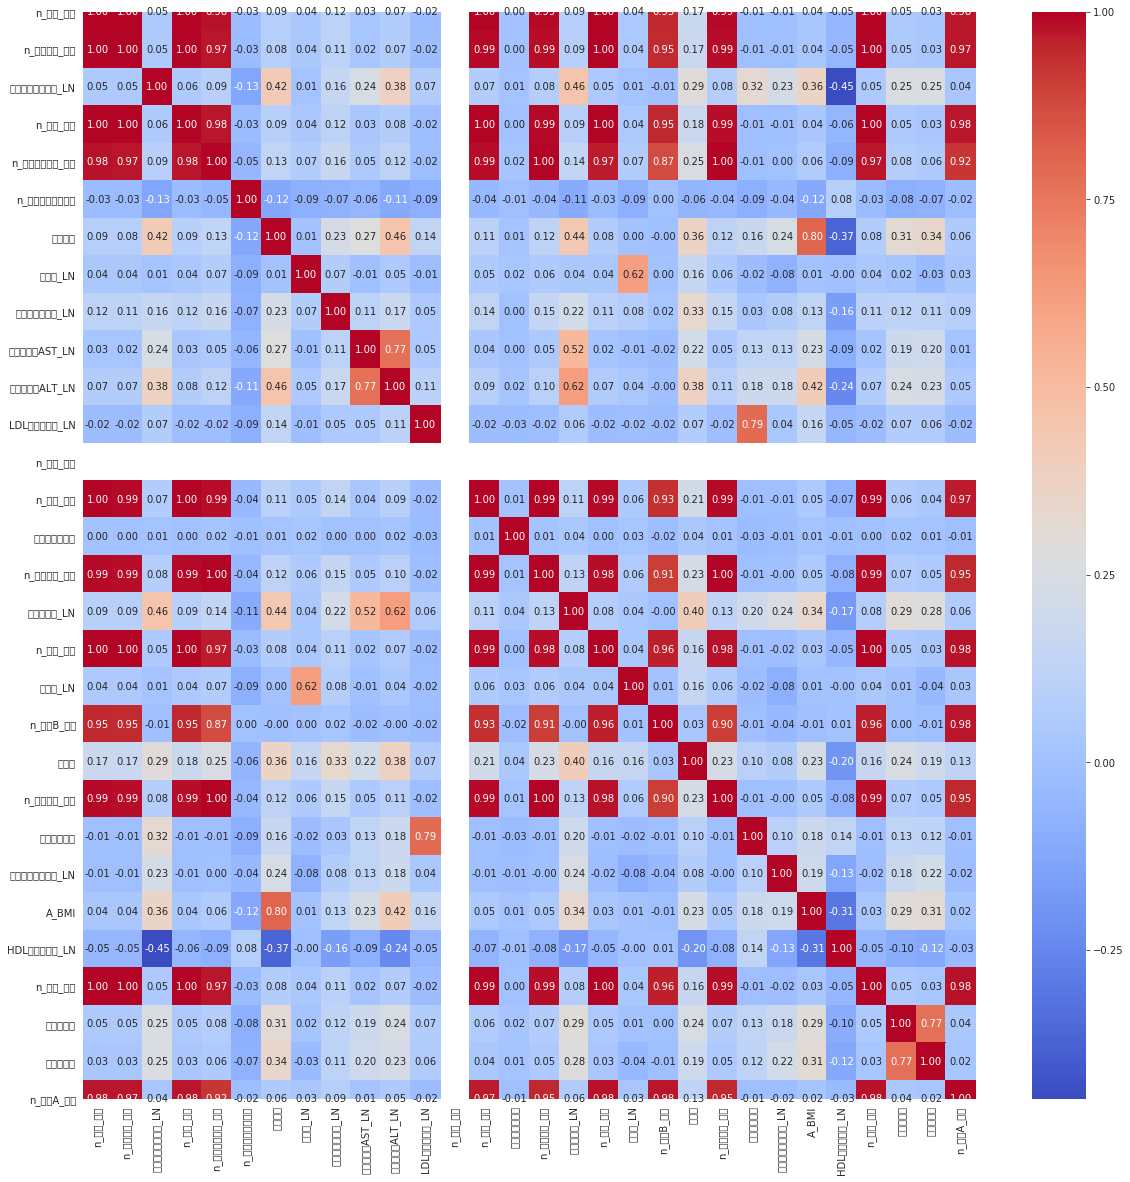

In [200]:
# 데이터 간의 상관관계 체크
# 수치형변수들과 Survived 변수의 상관관계 Matrix 시각화
plt.figure(figsize=(20, 20))
g = sns.heatmap(df_iv_final.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

### 4-5. 최종 모델 입력 변수 선정

In [213]:
# Feature Engineering 이후 불필요컬럼 Drop

not_remove_in_tg = '치석'
# # 1. 최종 모델에 입력 될 변수 선정(수치형 LN 기준 입력)
# need_cols = list(set(df_new.columns) - (set(num_ln_target_features + remove_target_candidates) - set([target_nm])))
need_cols = list(set(df_new.columns) - (set(num_ln_target_features + remove_target_candidates) - set([target_nm, not_remove_in_tg])))

# 2. Information Value 기준 변수 선정
# need_cols = IV_input_col + [target_nm]

df_final = df_new[need_cols].copy()
df_final.columns

Index(['n_위생_교육', 'n_정밀검진_권고', '신장5Cm단위', 'A_GTP', '트리글리세라이드_LN', 'n_불소_교육',
       'A_TRI', 'n_치주치료필요_권고', 'n_치과평균수진횟수', '허리둘레', 'A_시도', '시력우_LN',
       '혈청크레아티닌_LN', '혈청지오티AST_LN', '혈청지오티ALT_LN', 'LDL콜레스테롤_LN', 'n_기타_결과',
       'n_영양_교육', '치아우식증유무', 'A_HDL', '체중5Kg단위', 'A_요단백', 'n_치료필요_결과',
       '감마지티피_LN', 'A_diabetes', 'A_흡연상태', '치석', 'A_음주여부', 'n_주의_결과', 'A_청력좌',
       '시력좌_LN', 'A_HEMO', 'n_정상B_결과', 'A_성별', '혈색소', 'n_우식필요_권고', '총콜레스테롤',
       'A_청력우', '식전혈당공복혈당_LN', 'A_BMI', 'HDL콜레스테롤_LN', 'A_LDL', 'n_관리_권고',
       'A_CRE', '이완기혈압', '수축기혈압', 'n_정상A_결과', 'A_연령대5세단위'],
      dtype='object')

## 5. 모델 입력 전 최종 모델 입력에 맞게 입력 데이터 변형

In [0]:
data_x = df_final[df_final.columns.difference([target_nm])]
data_y = df_final[target_nm].astype('float64')

In [215]:
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

print("num_attribs: ", num_attribs)
print("cat_attribs: ", cat_attribs)

num_attribs:  ['n_위생_교육', 'n_정밀검진_권고', 'n_불소_교육', 'n_치주치료필요_권고', '트리글리세라이드_LN', 'n_주의_결과', '치석', 'n_치과평균수진횟수', '시력좌_LN', '허리둘레', 'n_정상B_결과', '시력우_LN', '혈청지오티ALT_LN', '혈청지오티AST_LN', '혈청크레아티닌_LN', 'LDL콜레스테롤_LN', '혈색소', 'n_우식필요_권고', 'A_BMI', 'n_기타_결과', '식전혈당공복혈당_LN', '총콜레스테롤', 'HDL콜레스테롤_LN', 'n_관리_권고', 'n_영양_교육', '이완기혈압', '수축기혈압', 'n_치료필요_결과', 'n_정상A_결과', '감마지티피_LN']
cat_attribs:  ['A_CRE', 'A_GTP', 'A_HDL', 'A_HEMO', 'A_LDL', 'A_TRI', 'A_diabetes', 'A_성별', 'A_시도', 'A_연령대5세단위', 'A_요단백', 'A_음주여부', 'A_청력우', 'A_청력좌', 'A_흡연상태', '신장5Cm단위', '체중5Kg단위']


### 5-1. 수치형 변수 정규화 및 Pipeline 연결



In [0]:
# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_encoder", OneHotEncoder(sparse=False), cat_attribs),
    ])

data_x_piped = full_pipeline.fit_transform(data_x)

data_y_piped = data_y.values

### 5-2. Train & Test 데이터 분리

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x_piped, data_y_piped, test_size = 0.3, random_state = 0)

In [218]:
display(train_x.shape)
display(test_x.shape)
display(train_y.shape)
display(test_y.shape)

(70000, 132)

(30000, 132)

(70000,)

(30000,)

### 5-3. 모델 선정 및 선언

In [0]:
#Machine Learning Algorithm (MLA) 선택 및 초기화

# 1차 Test 후 좋은 성능을 보인 모델 
# ['LogisticRegressionCV', 'RidgeClassifierCV', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'LinearDiscriminantAnalysis', 'XGBClassifier']
MLA = [ 
    #GLM
    linear_model.LogisticRegressionCV(),
    # linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    # linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    # naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    # neighbors.KNeighborsClassifier(),

    #Gaussian Processes
    # gaussian_process.GaussianProcessClassifier(),

    #Trees    
    # tree.DecisionTreeClassifier(),
    # tree.ExtraTreeClassifier(),

    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    # ensemble.BaggingClassifier(),
    # ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    # ensemble.RandomForestClassifier(),
       
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #SVM
    # svm.SVC(probability=True),
    # svm.NuSVC(probability=True),
    # svm.LinearSVC(),   

    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()
    ]

#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits=3, test_size=.3, train_size =.6, random_state=0) # run model 10x with 60/30 split intentionally leaving out 10%

In [220]:
# 모델평가를 위한 변수 세팅
score_pram = ['accuracy', 'precision','recall','f1']

#Create Table to Compare Canonical Models
MLA_Result_columns = ['ModelName','Dataset','Accuracy','Precision','Recall','F1']
MLA_compare = pd.DataFrame(columns = MLA_Result_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame(train_y)
print(MLA_predict.shape)

(70000, 1)


### 5-4. Model 실행 with Cross Validation

In [221]:
# index through MLA and save performance to table
row_index = 0
cv = 3
# 알고리즘을 하나씩 꺼내면서 loop
for alg in tqdm_notebook(MLA):
    print(alg, "algorithm modeling starts ... ")
    #알고리즘의 이름은 할당하고, [row_index, MLA Name]에 이름을 넣고, [row_index, MLA Parameters]에 알고리즘의 파라미터들을 할당
    Model_Name = alg.__class__.__name__
    
    cv_results = cross_validate(alg, train_x, train_y, cv=cv, scoring=score_pram, return_train_score=True, n_jobs=-1, verbose=1)
    
    train_cnt = 0
    test_cnt = 0
    
    for i in cv_results.keys():
      if("train" in i and train_cnt == 0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "TrainSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['train_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['train_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['train_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['train_f1'].mean(), "10.4f")
        row_index+=1
        train_cnt+=1
      elif("test" in i and test_cnt ==0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "TestSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['test_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['test_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['test_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['test_f1'].mean(), "10.4f")
        row_index+=1
        test_cnt+=1

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=None,
                  fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   42.4s finished


In [0]:
    # print("After Cross Validatin .. Just model fitting for Prediction with ", alg)
    # alg.fit(train_x, train_y)
    # MLA_predict[Model_Name] = alg.predict(test_x)
    # print(alg, "model is finished...")

In [223]:
MLA_compare

,ModelName,Dataset,Accuracy,Precision,Recall,F1
0,LogisticRegressionCV,TestSet,0.6124,0.6072,0.6288,0.6178
1,LogisticRegressionCV,TrainSet,0.6167,0.6115,0.6325,0.6218
2,RidgeClassifierCV,TestSet,0.6125,0.6070,0.6305,0.6185
3,RidgeClassifierCV,TrainSet,0.6168,0.6111,0.6348,0.6227
4,SGDClassifier,TestSet,0.6039,0.5883,0.6839,0.6323
5,SGDClassifier,TrainSet,0.6044,0.5888,0.6842,0.6327
6,BernoulliNB,TestSet,0.5806,0.5803,0.5721,0.5761
7,BernoulliNB,TrainSet,0.5818,0.5814,0.5733,0.5773
8,AdaBoostClassifier,TestSet,0.6119,0.6052,0.6365,0.6204
9,AdaBoostClassifier,TrainSet,0.6168,0.6097,0.6421,0.6255


In [224]:
# MLA_predict
['LogisticRegressionCV', 'RidgeClassifierCV', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'LinearDiscriminantAnalysis', 'XGBClassifier']

['LogisticRegressionCV',
 'RidgeClassifierCV',
 'AdaBoostClassifier',
 'GradientBoostingClassifier',
 'LinearDiscriminantAnalysis',
 'XGBClassifier']

### AUC Graph 그리는 함수 선언

In [0]:
def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [0]:
# #barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
# plt.figure(figsize=(8,6))
# sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, palette=sns.husl_palette(n_colors=20,l=.7))

# #prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
# plt.title('Machine Learning Algorithm Accuracy Score \n')
# plt.xlabel('Accuracy Score (%)')
# plt.ylabel('Algorithm')
# plt.show()

In [0]:
# Deep Learning 평가를 위한 평가 함수 정의
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [0]:
def mlp_model():
  input_dim = train_x.shape[1]
  batch_size = 64
#   epochs = 50

  model = Sequential()

  # 첫 번째 Layer (Input layer)
  model.add(Dense(input_dim=input_dim, init='glorot_uniform', activation=activation, output_dim=128))
  # model.add(Dropout(0.2)) # 30% 정도를 Drop 

  # 두 번째 Layer (Hidden layer 1)
  model.add(Dense(output_dim=128, init='glorot_uniform', activation=activation))
  # model.add(Dropout(0.2)) # 30% 정도를 Drop 

  # 세 번째 Layer (Hidden layer 2)
  model.add(Dense(output_dim=256, init='glorot_uniform', activation=activation))
  # model.add(Dropout(0.2)) # 30% 정도를 Drop 

  # 네 번째 Layer (Hidden layer 3)
  model.add(Dense(output_dim=512, init='glorot_uniform', activation=activation))
  # model.add(Dropout(0.2)) # 30% 정도를 Drop 

  # # 다섯 번째 Layer (Hidden layer 4)
  model.add(Dense(output_dim=512, init='glorot_uniform', activation=activation))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # 여섯 번째 Layer (Output layer)
  model.add(Dense(output_dim=1))
  model.add(Activation("sigmoid"))

  # Cost function 및 Optimizer 설정 # binary class 분류이므로 binary_crossentropy 사용 # Adam optimizer 사용
  # ffn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1score])
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', precision, recall, f1score])
  
  return model

# model training
# hist = ffn_model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)

lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
activation = lrelu

model_dl = KerasClassifier(build_fn = mlp_model, epochs = 15, verbose = 1)

In [229]:
model_dl_run = model_dl.fit(train_x, train_y)

Epoch 1/15
70000/70000 [==============================] - 14s 204us/step - loss: 0.6674 - acc: 0.6009 - precision: 0.5977 - recall: 0.6233 - f1score: 0.5940
Epoch 2/15
70000/70000 [==============================] - 14s 197us/step - loss: 0.6613 - acc: 0.6103 - precision: 0.6052 - recall: 0.6444 - f1score: 0.6117
Epoch 3/15
70000/70000 [==============================] - 14s 196us/step - loss: 0.6594 - acc: 0.6119 - precision: 0.6093 - recall: 0.6299 - f1score: 0.6073
Epoch 4/15
70000/70000 [==============================] - 14s 196us/step - loss: 0.6584 - acc: 0.6127 - precision: 0.6091 - recall: 0.6331 - f1score: 0.6082
Epoch 5/15
70000/70000 [==============================] - 14s 195us/step - loss: 0.6581 - acc: 0.6135 - precision: 0.6130 - recall: 0.6243 - f1score: 0.6054
Epoch 6/15
70000/70000 [==============================] - 14s 198us/step - loss: 0.6583 - acc: 0.6150 - precision: 0.6141 - recall: 0.6272 - f1score: 0.6087
Epoch 7/15
70000/70000 [==============================] - 

30000/30000 [==============================] - 1s 40us/step
Accuracy: 0.61187
Confusion Matrix: 
 [[9092 5785]
 [5859 9264]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0       0.61      0.61      0.61     14877
         1.0       0.62      0.61      0.61     15123

    accuracy                           0.61     30000
   macro avg       0.61      0.61      0.61     30000
weighted avg       0.61      0.61      0.61     30000

roc_auc score is :  0.6118607948531792


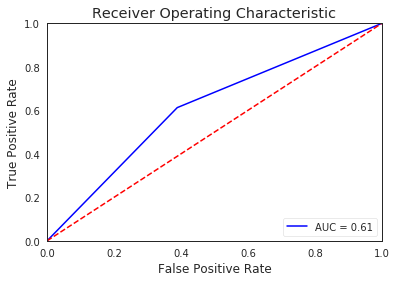

In [230]:
pred_y_dl = model_dl.predict(test_x)
pred_y_dl = (pred_y_dl>0.5)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_dl)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_dl))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_dl))

roc_auc_dl = roc_auc_score(test_y, pred_y_dl)
print("roc_auc score is : ", roc_auc_dl)

fpr, tpr, threshold = roc_curve(test_y, pred_y_dl)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

### 성능이 좋은 모델들의 Hyperparameter Tuning

In [0]:
cv_split = ShuffleSplit(n_splits=10, test_size=.3, train_size =.6, random_state=42) # run model 10x with 60/30 split intentionally leaving out 10%
verboseNo = 1

In [0]:
# LogisticRegressionCV
model_lr = linear_model.LogisticRegression()

param_grid = {'C': np.logspace(-3,3,7), 'penalty': ['l1', 'l2']}

grid_lr = GridSearchCV(model_lr,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_lr.fit(train_x, train_y)
grid_lr_best = grid_lr.best_estimator_
print(grid_lr_best)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [0]:
pred_y_lr = grid_lr_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_lr)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_lr))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_lr))

roc_auc_lr = roc_auc_score(test_y, pred_y_lr)
print(roc_auc_lr)

fpr, tpr, threshold = roc_curve(test_y, pred_y_lr)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# RidgeClassifierCV
model_rc = linear_model.RidgeClassifier()

param_grid = {'alpha':[1e-3, 1e-2, 1e-1, 1]}

grid_rc = GridSearchCV(model_rc,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_rc.fit(train_x, train_y)
grid_rc_best = grid_rc.best_estimator_
print(grid_rc_best)

In [0]:
pred_y_rc = grid_rc_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_rc)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_rc))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_rc))

roc_auc_rc = roc_auc_score(test_y, pred_y_rc)
print(roc_auc_rc)

fpr, tpr, threshold = roc_curve(test_y, pred_y_rc)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# AdaBoostClassifier
model_ab = ensemble.AdaBoostClassifier()

param_grid = {'n_estimators': [16, 32]}

grid_ab = GridSearchCV(model_ab,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_ab.fit(train_x, train_y)
grid_ab_best = grid_ab.best_estimator_
print(grid_ab_best)

In [0]:
pred_y_ab = grid_ab_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_ab)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_ab))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_ab))

roc_auc_ab = roc_auc_score(test_y, pred_y_ab)
print(roc_auc_ab)

fpr, tpr, threshold = roc_curve(test_y, pred_y_ab)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# GradientBoostingClassifier
model_gb = ensemble.GradientBoostingClassifier()

param_grid = {'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0]}

grid_gb = GridSearchCV(model_gb,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_gb.fit(train_x, train_y)
grid_gb_best = grid_gb.best_estimator_
print(grid_gb_best)

In [0]:
pred_y_gb = grid_gb_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_gb)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_gb))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_gb))

roc_auc_gb = roc_auc_score(test_y, pred_y_gb)
print(roc_auc_gb)

fpr, tpr, threshold = roc_curve(test_y, pred_y_gb)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# LinearDiscriminantAnalysis
## LDA(선형판별분석(Linear Discriminant Analysis):데이터를 특정 한 축에 사영(projection)한 후에 두 범주를 잘 구분할 수 있는 직선을 찾는 걸 목표
model_ld = discriminant_analysis.LinearDiscriminantAnalysis()

param_grid = {'solver': ['svd', 'lsqr']}

grid_ld = GridSearchCV(model_ld,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_ld.fit(train_x, train_y)
grid_ld_best = grid_ld.best_estimator_
print(grid_ld_best)

In [0]:
pred_y_ld = grid_ld_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_ld)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_ld))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_ld))

roc_auc_ld = roc_auc_score(test_y, pred_y_ld)
print(roc_auc_ld)

fpr, tpr, threshold = roc_curve(test_y, pred_y_ld)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# XGBClassifier
model_xg = XGBClassifier()

param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

grid_xg = GridSearchCV(model_xg,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_xg.fit(train_x, train_y)
grid_xg_best = grid_xg.best_estimator_
print(grid_xg_best)

In [0]:
pred_y_xg = grid_xg_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_xg)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_xg))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_xg))

roc_auc_xg = roc_auc_score(test_y, pred_y_xg)
print(roc_auc_xg)

fpr, tpr, threshold = roc_curve(test_y, pred_y_xg)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# # XGBoost Test
# xgb_clf = XGBClassifier(nthreads=-1)

# one_to_left = st.beta(100, 1)  
# from_zero_positive = st.expon(0, 50)

# params = {  
#     "n_estimators": st.randint(3, 100),
#     "max_depth": st.randint(3, 40),
#     "learning_rate": st.uniform(0.05, 0.9),
#     "colsample_bytree": one_to_left,
#     "subsample": one_to_left,
#     "gamma": st.uniform(0, 10),
#     'reg_alpha': from_zero_positive,
#     "min_child_weight": from_zero_positive,
# }

# rand_search = RandomizedSearchCV(xgb_clf, params, n_jobs=1, cv=100)  
# rand_search.fit(x_train, y_train) 
# xgb_best = rand_search.best_estimator_
# print(rand_search.best_estimator_)

## 결과 앙상블로 모델 결과 최적화

In [0]:
votingC = VotingClassifier(estimators=[('model_lr',grid_lr_best),('model_ab', grid_ab_best),
                                       ('model_gb', grid_gb_best),('model_ld', grid_ld_best), ('model_xg',grid_xg_best)], 
                           voting='soft', n_jobs=-1)

votingC = votingC.fit(train_x, train_y)

In [0]:
# soft voting을 통한 성능 향상
pred_y_vc = votingC.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_vc)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_vc))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_vc))

roc_auc_vc = roc_auc_score(test_y, pred_y_vc)
print(roc_auc_vc)

fpr, tpr, threshold = roc_curve(test_y, pred_y_vc)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
votingC = VotingClassifier(estimators=[('model_lr',grid_lr_best),('model_ab', grid_ab_best),('model_gb', grid_gb_best)
                                       ,('model_ld', grid_ld_best), ('model_xg',grid_xg_best), ('model_dl',model_dl)], 
                           voting='soft')

votingC = votingC.fit(train_x, train_y)

In [0]:
# soft voting을 통한 성능 향상
pred_y_vc = votingC.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_vc)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_vc))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_vc))

roc_auc_vc = roc_auc_score(test_y, pred_y_vc)
print(roc_auc_vc)

fpr, tpr, threshold = roc_curve(test_y, pred_y_vc)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)